Diego García Maroto (diegar20@ucm.es)

# Práctica 2: Análisis de extremos, análisis espectral y filtros

In [1]:

# Módulos básicos y otros
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib.cm as cm

# Estadística
from scipy import stats 
from scipy import special

# Cartografía 
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader

# Lectura de datos
from netCDF4 import Dataset
import xarray as xr

# Índices Climáticos
from xclim.core.calendar import percentile_doy
from xclim.indices import tn10p, tx10p

from scipy.fft import fft 
from statsmodels.tsa import stattools 
from scipy import signal


Vamos a calcular los siguientes indices de extremos:

![title](./img/index.png)

Lectura de datos (necesitaremos tanto Tmax como Tmin):

In [2]:
path = '/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/datos/'
file_max = 'tmax_pen.nc'
data_max = xr.open_dataset(path+file_max)
file_min = 'tmin_pen.nc'
data_min = xr.open_dataset(path+file_min)
display(data_max)
data_min

<xarray.Dataset>
Dimensions:  (lon: 230, lat: 190, Time: 41638)
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Data variables:
    tx       (Time, lat, lon) float32 ...
Attributes: (12/13)
    title:             Daily maximum temperature of peninsular Spain
    history:           version 1.0
    keywords:          daily, maximum temperature, peninsular Spain, Spain
    creator_name:      Roberto Serrano-Notivoli; Martin de Luis; Santiago Beg...
    maintainer_name:   Roberto Serrano-Notivoli
    maintainer_email:  rs@unizar.es
    ...                ...
    processing_level:  Quality-controlled. Final values.
    acknowledgment:    This study was supported by research projects financed...
    units:             Celsius degrees
    id:                STEAD
    sources:           AEMET and MAGRAMA
    naming_authority:  Spanish TEmperature At Daily scale

<xarray.Dataset>
Dimensions:  (lon: 230, lat: 190, Time: 41638)
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Data variables:
    tn       (Time, lat, lon) float32 ...
Attributes: (12/13)
    title:             Daily minimum temperature of peninsular Spain
    history:           version 1.0
    keywords:          daily, minimum temperature, peninsular Spain, Spain
    creator_name:      Roberto Serrano-Notivoli; Martin de Luis; Santiago Beg...
    maintainer_name:   Roberto Serrano-Notivoli
    maintainer_email:  rs@unizar.es
    ...                ...
    processing_level:  Quality-controlled. Final values.
    acknowledgment:    This study was supported by research projects financed...
    units:             Celsius degrees
    id:                STEAD
    sources:           AEMET and MAGRAMA
    naming_authority:  Spanish TEmperature At Daily scale

In [3]:
# Separamos las variables (las lat y lon son las mismas al ser la misma base de datos)
lon = data_min.lon
lat = data_min.lat
tmin = data_min.tn
tmax = data_max.tx
display(tmax)
display(tmin)

<xarray.DataArray 'tx' (Time: 41638, lat: 190, lon: 230)>
[1819580600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Attributes:
    units:      Celsius degrees
    long_name:  Maximum temperature

<xarray.DataArray 'tn' (Time: 41638, lat: 190, lon: 230)>
[1819580600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Attributes:
    units:      Celsius degrees
    long_name:  Minimum temperature

---

## ESTUDIO NOCHES FRÍAS


In [4]:
# Defino funciones para calcular el índice y los percentiles mediante el módulo xclim
def cold_nights_xclim(tmin:xr.DataArray, period:list, ref_period=['1961','1990']):
    try:
        tmin.time
        print('Funciono bien :)')
    except: 
        tmin = tmin.rename({'Time': 'time'})
        print('Te he cambiado el tiempo')
    #tmin = tmin.convert_calendar('noleap',dim='time')
    print('>> Calculando percentiles')
    tmin.attrs['units'] = 'degC'
    base = tmin.sel(time=slice('1961','1990'))
    tmin_per = percentile_doy(base, per=10).sel(percentiles=10)
    print('>> Percentiles calculados')
    print('>> Calculando indice')
    num_cold = tn10p(tmin.sel(time=slice(period[0],period[1])), tmin_per)
    percent_cold_nights = num_cold/365*100
    print('>> Índice calculado')
    return tmin_per, percent_cold_nights

def cold_days_xclim(tmax:xr.DataArray, period:list, ref_period=['1961','1990']):
    try: tmax.time
    except: tmax = tmax.rename({'Time': 'time'})
    #tmax = tmax.convert_calendar('noleap',dim='time')
    print('>> Calculando percentiles')
    tmax.attrs['units'] = 'degC'
    base = tmax.sel(time=slice('1961','1990'))
    tmax_per = percentile_doy(base, per=10).sel(percentiles=10)
    print('>> Percentiles calculados')
    print('>> Calculando indice')
    num_cold = tn10p(tmax.sel(time=slice(period[0],period[1])), tmax_per)
    percent_cold_days = num_cold/365*100
    print('>> Índice calculado')
    return tmax_per, percent_cold_days


In [5]:

tmin_p10_E = xr.open_dataarray('/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/outs/tmin_p10_E.nc')
percent_cold_nights_E = xr.open_dataarray('/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/outs/percent_cold_nights_E.nc')


In [6]:
tmin_p10_E

<xarray.DataArray 'per' (lat: 152, lon: 98, dayofyear: 366)>
[5451936 values with dtype=float64]
Coordinates:
  * lon          (lon) float64 -1.951 -1.892 -1.834 -1.775 ... 3.607 3.665 3.724
  * lat          (lat) float64 43.0 42.95 42.91 42.86 ... 36.34 36.29 36.25 36.2
    percentiles  int32 ...
  * dayofyear    (dayofyear) int32 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Attributes:
    units:               °C
    long_name:           Minimum temperature
    climatology_bounds:  ['1961-01-01', '1990-12-31']
    window:              5
    alpha:               0.3333333333333333
    beta:                0.3333333333333333
    history:             [2022-11-17 00:34:29] per: percentile_doy(arr=tn, wi...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<xarray.DataArray ()>
array(20.84114396)
Coordinates:
    percentiles  int32 ...


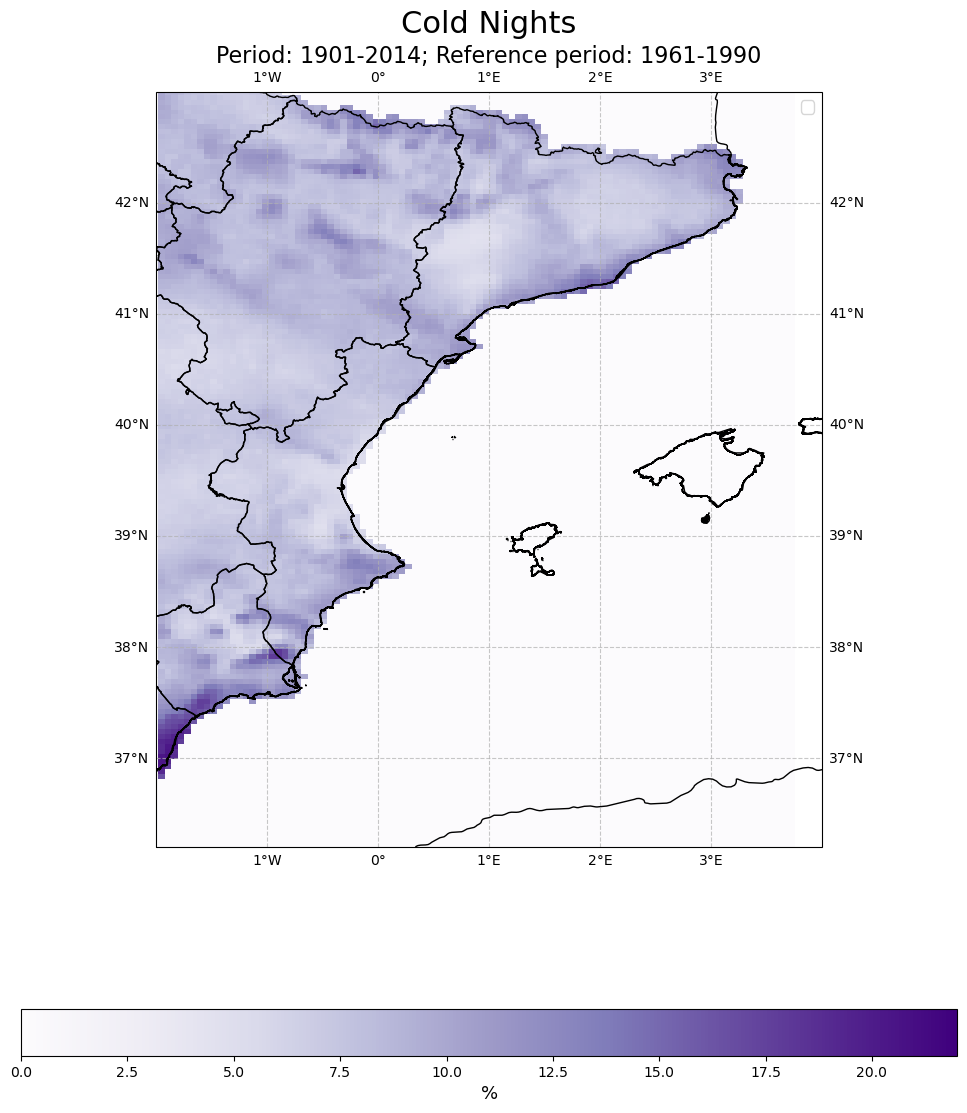

In [7]:

# Representación 
mapas = '/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(mapas).geometries())


fig, ax = plt.subplots(figsize=(12,12), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cold Nights',size=22)
plt.title('Period: 1901-2014; Reference period: 1961-1990',size=16)


ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)

ax.set_extent([-2,4,36.2,43], ccrs.PlateCarree())
cmap = 'Purples'

var = percent_cold_nights_E.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())


cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=f'%',size=13)
cbar.ax.set_xlim(0, 22)


ax.coastlines(resolution='10m')

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), 
                  edgecolor='black', facecolor='None', alpha=1)


ax.legend(prop={'size':12})
plt.tight_layout()

<xarray.DataArray ()>
array(35.77694236)
Coordinates:
    percentiles  int32 10


(-90.0, 90.0)

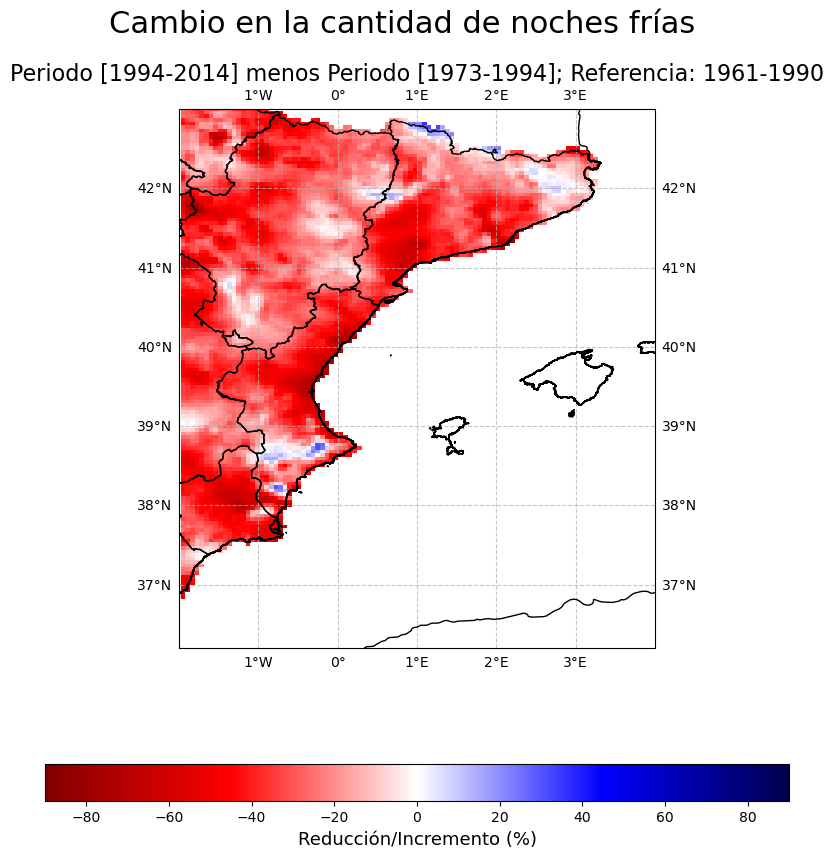

In [8]:
fname = '/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())


fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cambio en la cantidad de noches frías',size=22)
plt.title('Periodo [1994-2014] menos Periodo [1973-1994]; Referencia: 1961-1990',size=16)
ax.coastlines(resolution='10m')#, linewidth=2)

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)


ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)

ax.set_extent([-2,4,36.2,43], ccrs.PlateCarree())
cmap = cm.get_cmap('seismic_r')
vmin = -90
vmax = 90


var = (percent_cold_nights_E.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_nights_E.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_nights_E.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())



cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=u'Reducción/Incremento (%)',size=13)
cbar.ax.set_xlim(vmin, vmax)

<xarray.DataArray ()>
array(23.28767123)
Coordinates:
    percentiles  int32 ...
<xarray.DataArray ()>
array(12.55356516)
Coordinates:
    percentiles  int32 ...


(0.0, 22.0)

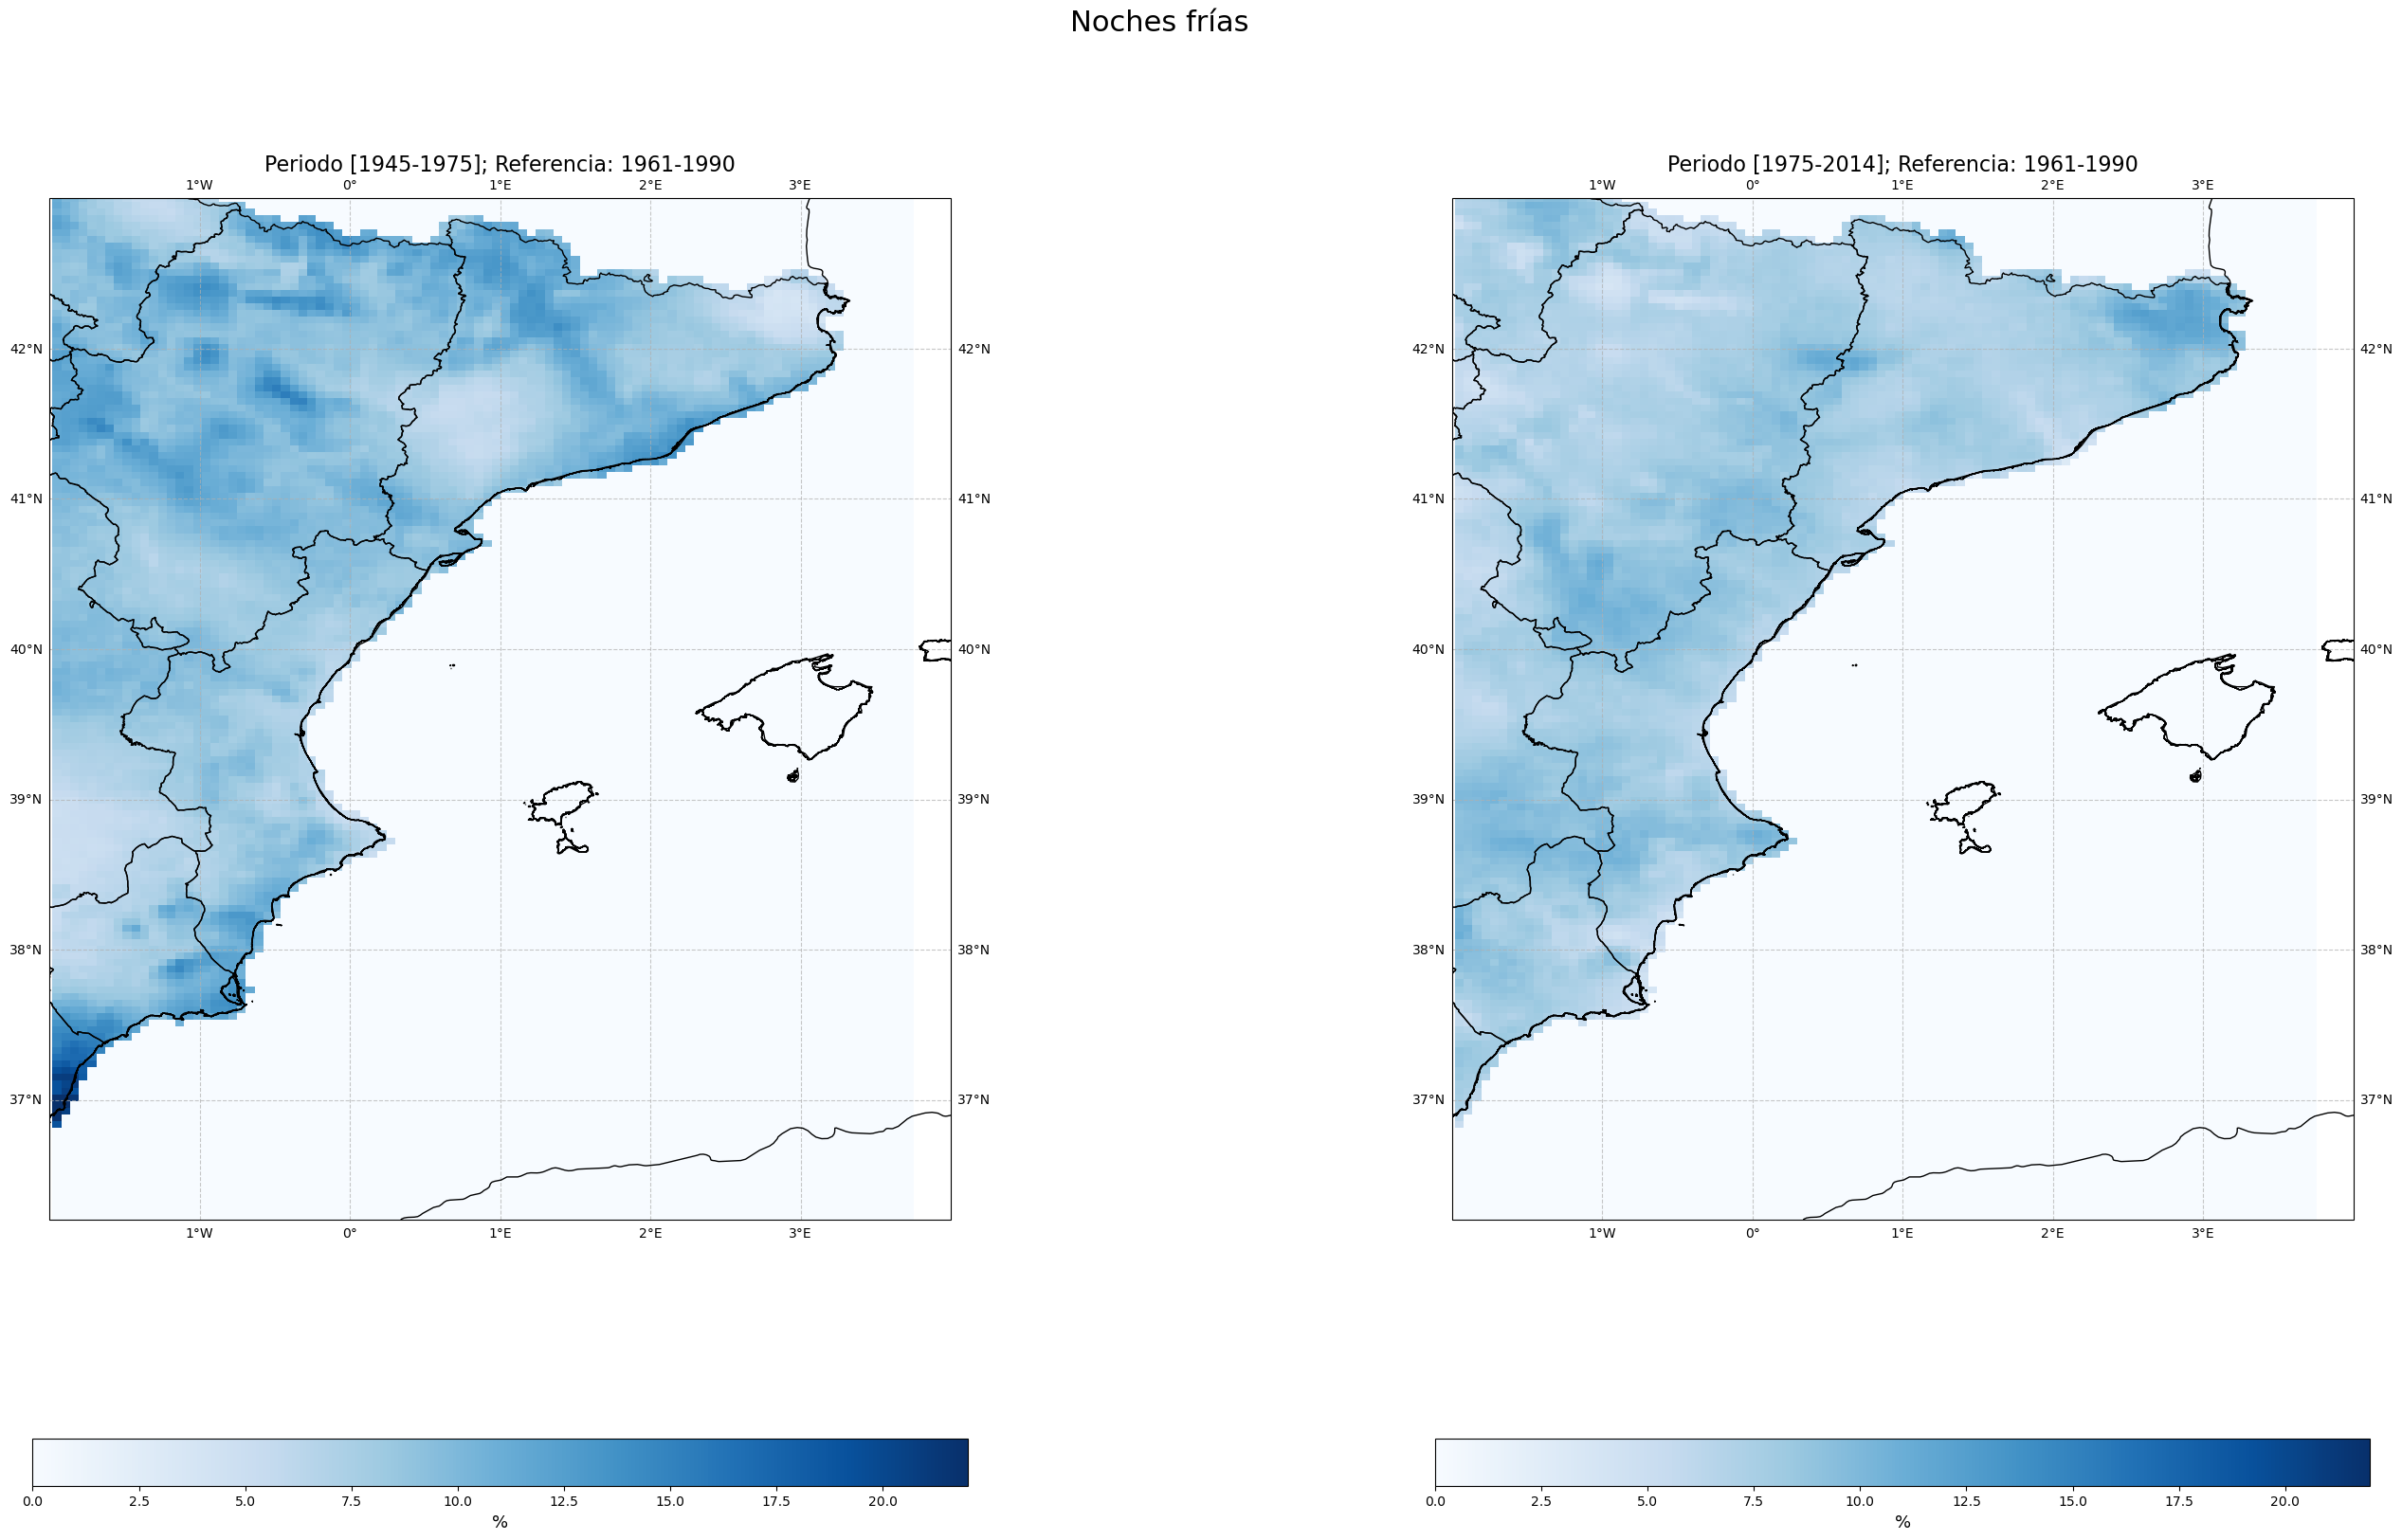

In [9]:
fname = '/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())


fig, (ax,ax2) = plt.subplots(1,2,figsize=(35, 20))

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())

plt.suptitle('Noches frías',size=22)
plt.title('Periodo [1945-1975]; Referencia: 1961-1990',size=16)
ax.coastlines(resolution='10m')#, linewidth=2)
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)
ax.set_extent([-2,4,36.2,43], ccrs.PlateCarree())
cmap = cm.get_cmap('Blues')
var = percent_cold_nights_E[45:75].mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label='%',size=13)
cbar.ax.set_xlim(0, 22)

ax2=plt.subplot(1,2,2,projection=ccrs.PlateCarree())

plt.suptitle('Noches frías',size=22)
plt.title('Periodo [1975-2014]; Referencia: 1961-1990',size=16)
ax2.coastlines(resolution='10m')#, linewidth=2)
ax2.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax2.set_global() # added following an answer to my question
#ax.gridlines()
ax2.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)
ax2.set_extent([-2,4,36.2,43], ccrs.PlateCarree())
cmap = cm.get_cmap('Blues')
var = percent_cold_nights_E[75:].mean(dim='time')
im = ax2.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())
cbar = fig.colorbar(im,ax=ax2,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label='%',size=13)
cbar.ax.set_xlim(0, 22)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


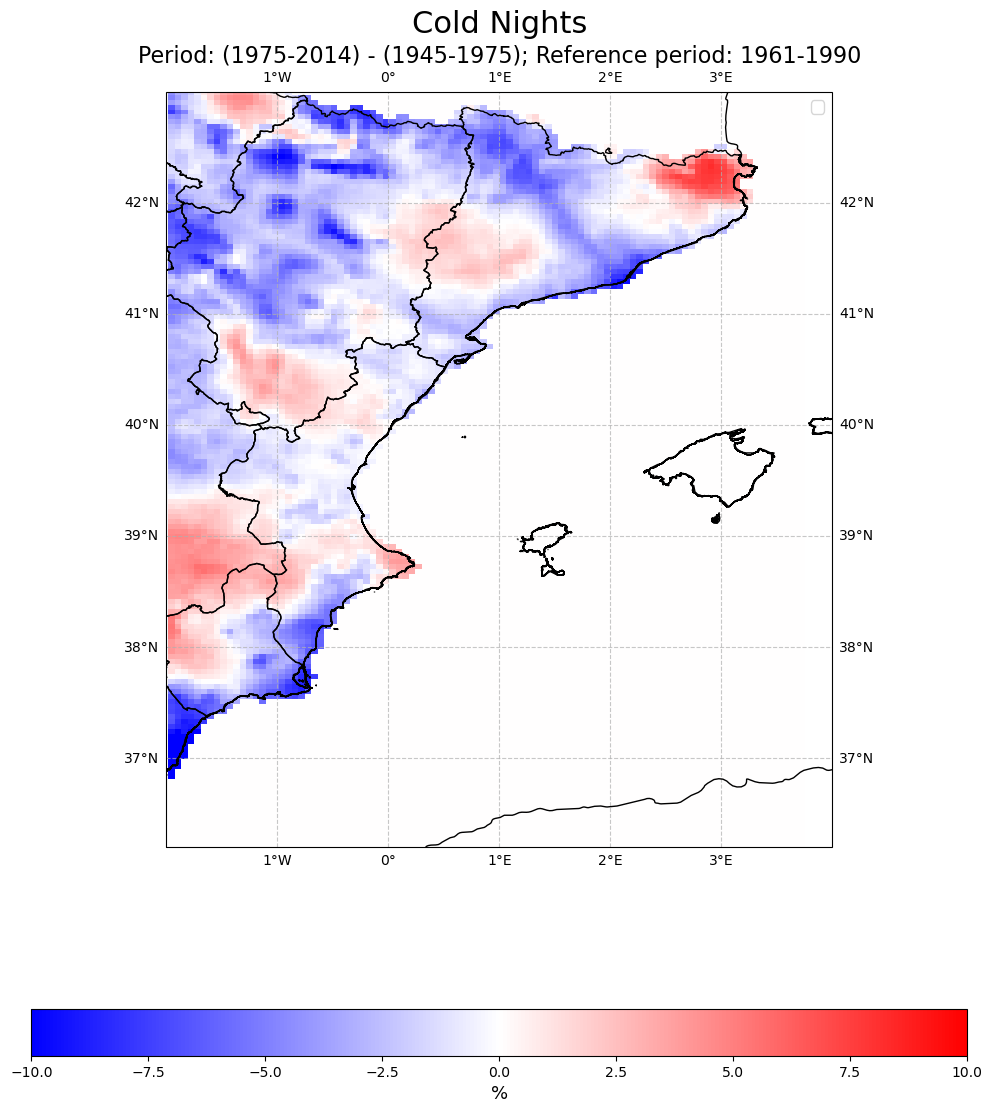

In [10]:
fname = '/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())

fig, ax = plt.subplots(figsize=(12,12), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
plt.suptitle('Cold Nights',size=22)
plt.title('Period: (1975-2014) - (1945-1975); Reference period: 1961-1990',size=16)
ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)
ax.set_extent([-2,4,36.2,43], ccrs.PlateCarree())

cmap = 'bwr'
var1 = percent_cold_nights_E[75:].mean(dim='time')
var2 = percent_cold_nights_E[45:75].mean(dim='time')
var3 = var1-var2
im = ax.pcolormesh(var3.lon,var3.lat,var3.squeeze(),cmap=cmap,vmin=-10, vmax=10, transform =ccrs.PlateCarree()) 
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=f'%',size=13)
cbar.ax.set_xlim(-10, 10)

ax.coastlines(resolution='10m')#, linewidth=2)
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax.set_ylim(36.2,43)
ax.set_xlim(-2,4)
ax.legend(prop={'size':12})
plt.tight_layout()

# Días frios 

In [11]:


def cold_days_xclim(tmax:xr.DataArray, period:list, ref_period=['1961','1990']):
    try: tmax.time
    except: tmax = tmax.rename({'Time': 'time'})
    #tmax = tmax.convert_calendar('noleap',dim='time')
    print('>> Calculando percentiles')
    tmax.attrs['units'] = 'degC'
    base = tmax.sel(time=slice('1961','1990'))
    tmax_per = percentile_doy(base, per=10).sel(percentiles=10)
    print('>> Percentiles calculados')
    print('>> Calculando indice')
    num_cold = tn10p(tmax.sel(time=slice(period[0],period[1])), tmax_per)
    percent_cold_days = num_cold/365*100
    print('>> Índice calculado')
    return tmax_per, percent_cold_days

In [12]:

tmax_p10_E = xr.open_dataarray('/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/outs/tmax_p10_E.nc')
percent_cold_days_E = xr.open_dataarray('/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/outs/percent_cold_days_E.nc')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<xarray.DataArray ()>
array(15.71497236)
Coordinates:
    percentiles  int32 ...


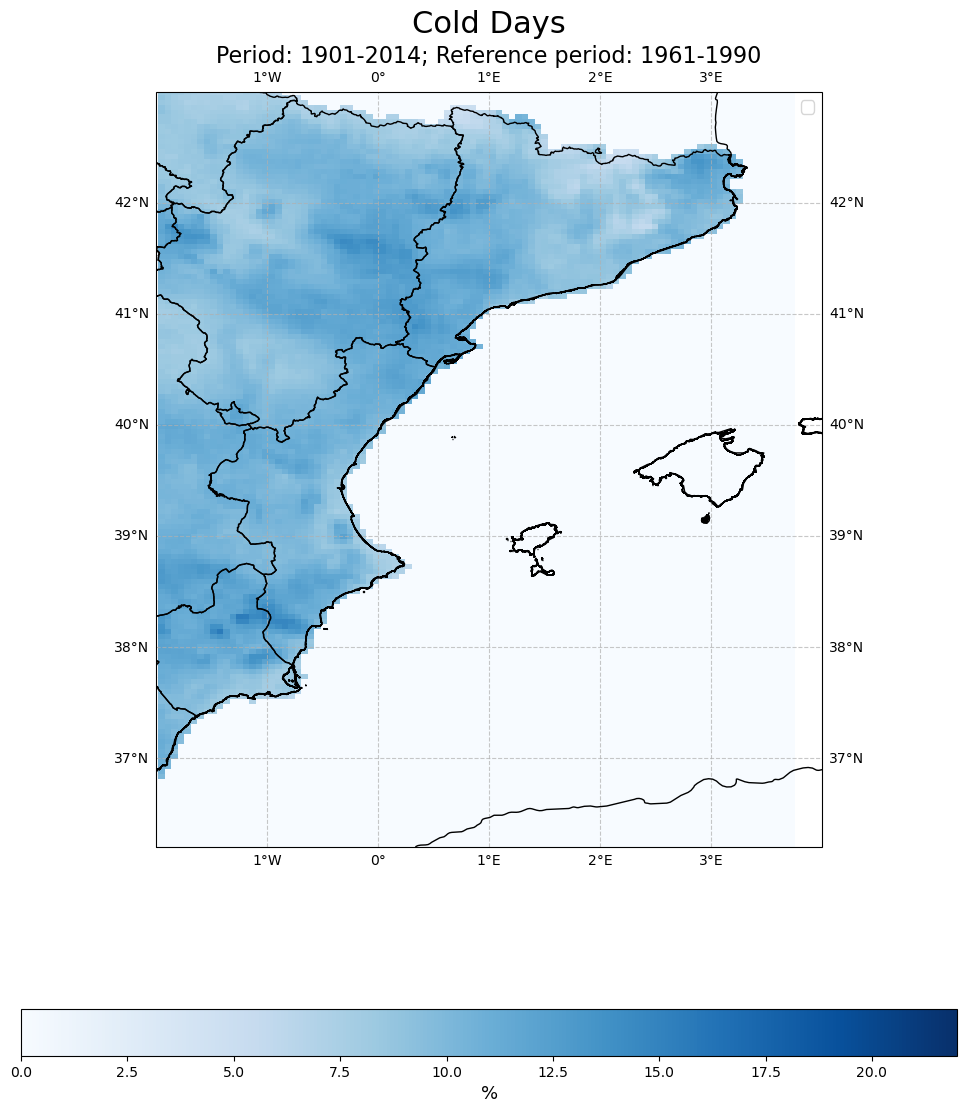

In [13]:
# Representación 
mapas = '/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(mapas).geometries())


fig, ax = plt.subplots(figsize=(12,12), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cold Days',size=22)
plt.title('Period: 1901-2014; Reference period: 1961-1990',size=16)


ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)

ax.set_extent([-2,4,36.2,43], ccrs.PlateCarree())
cmap = 'Blues'

var = percent_cold_days_E.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())


cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=f'%',size=13)
cbar.ax.set_xlim(0, 22)


ax.coastlines(resolution='10m')

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), 
                  edgecolor='black', facecolor='None', alpha=1)


ax.legend(prop={'size':12})
plt.tight_layout()

<xarray.DataArray ()>
array(75.29467232)
Coordinates:
    percentiles  int32 10


(-90.0, 90.0)

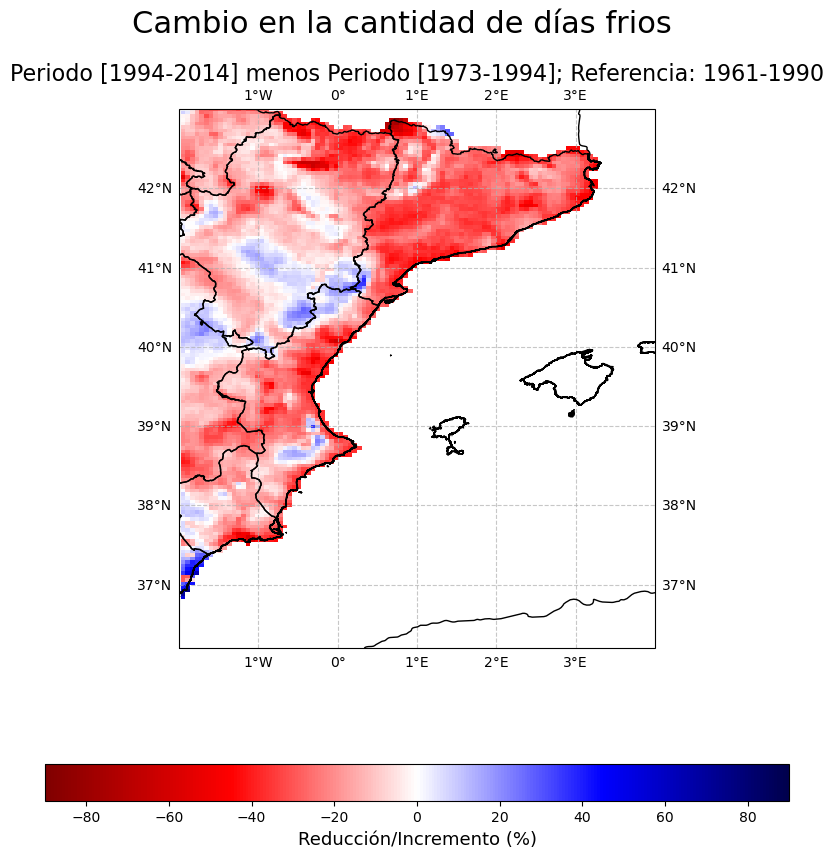

In [14]:
mapas = '/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(mapas).geometries())


fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cambio en la cantidad de días frios',size=22)
plt.title('Periodo [1994-2014] menos Periodo [1973-1994]; Referencia: 1961-1990',size=16)
ax.coastlines(resolution='10m')#, linewidth=2)

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)


ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)

ax.set_extent([-2,4,36.2,43], ccrs.PlateCarree())
cmap = cm.get_cmap('seismic_r')
vmin = -90
vmax = 90


var = (percent_cold_days_E.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_days_E.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_days_E.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())



cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=u'Reducción/Incremento (%)',size=13)
cbar.ax.set_xlim(vmin, vmax)

<xarray.DataArray ()>
array(13.49771689)
Coordinates:
    percentiles  int32 ...
<xarray.DataArray ()>
array(13.23498419)
Coordinates:
    percentiles  int32 ...


(0.0, 22.0)

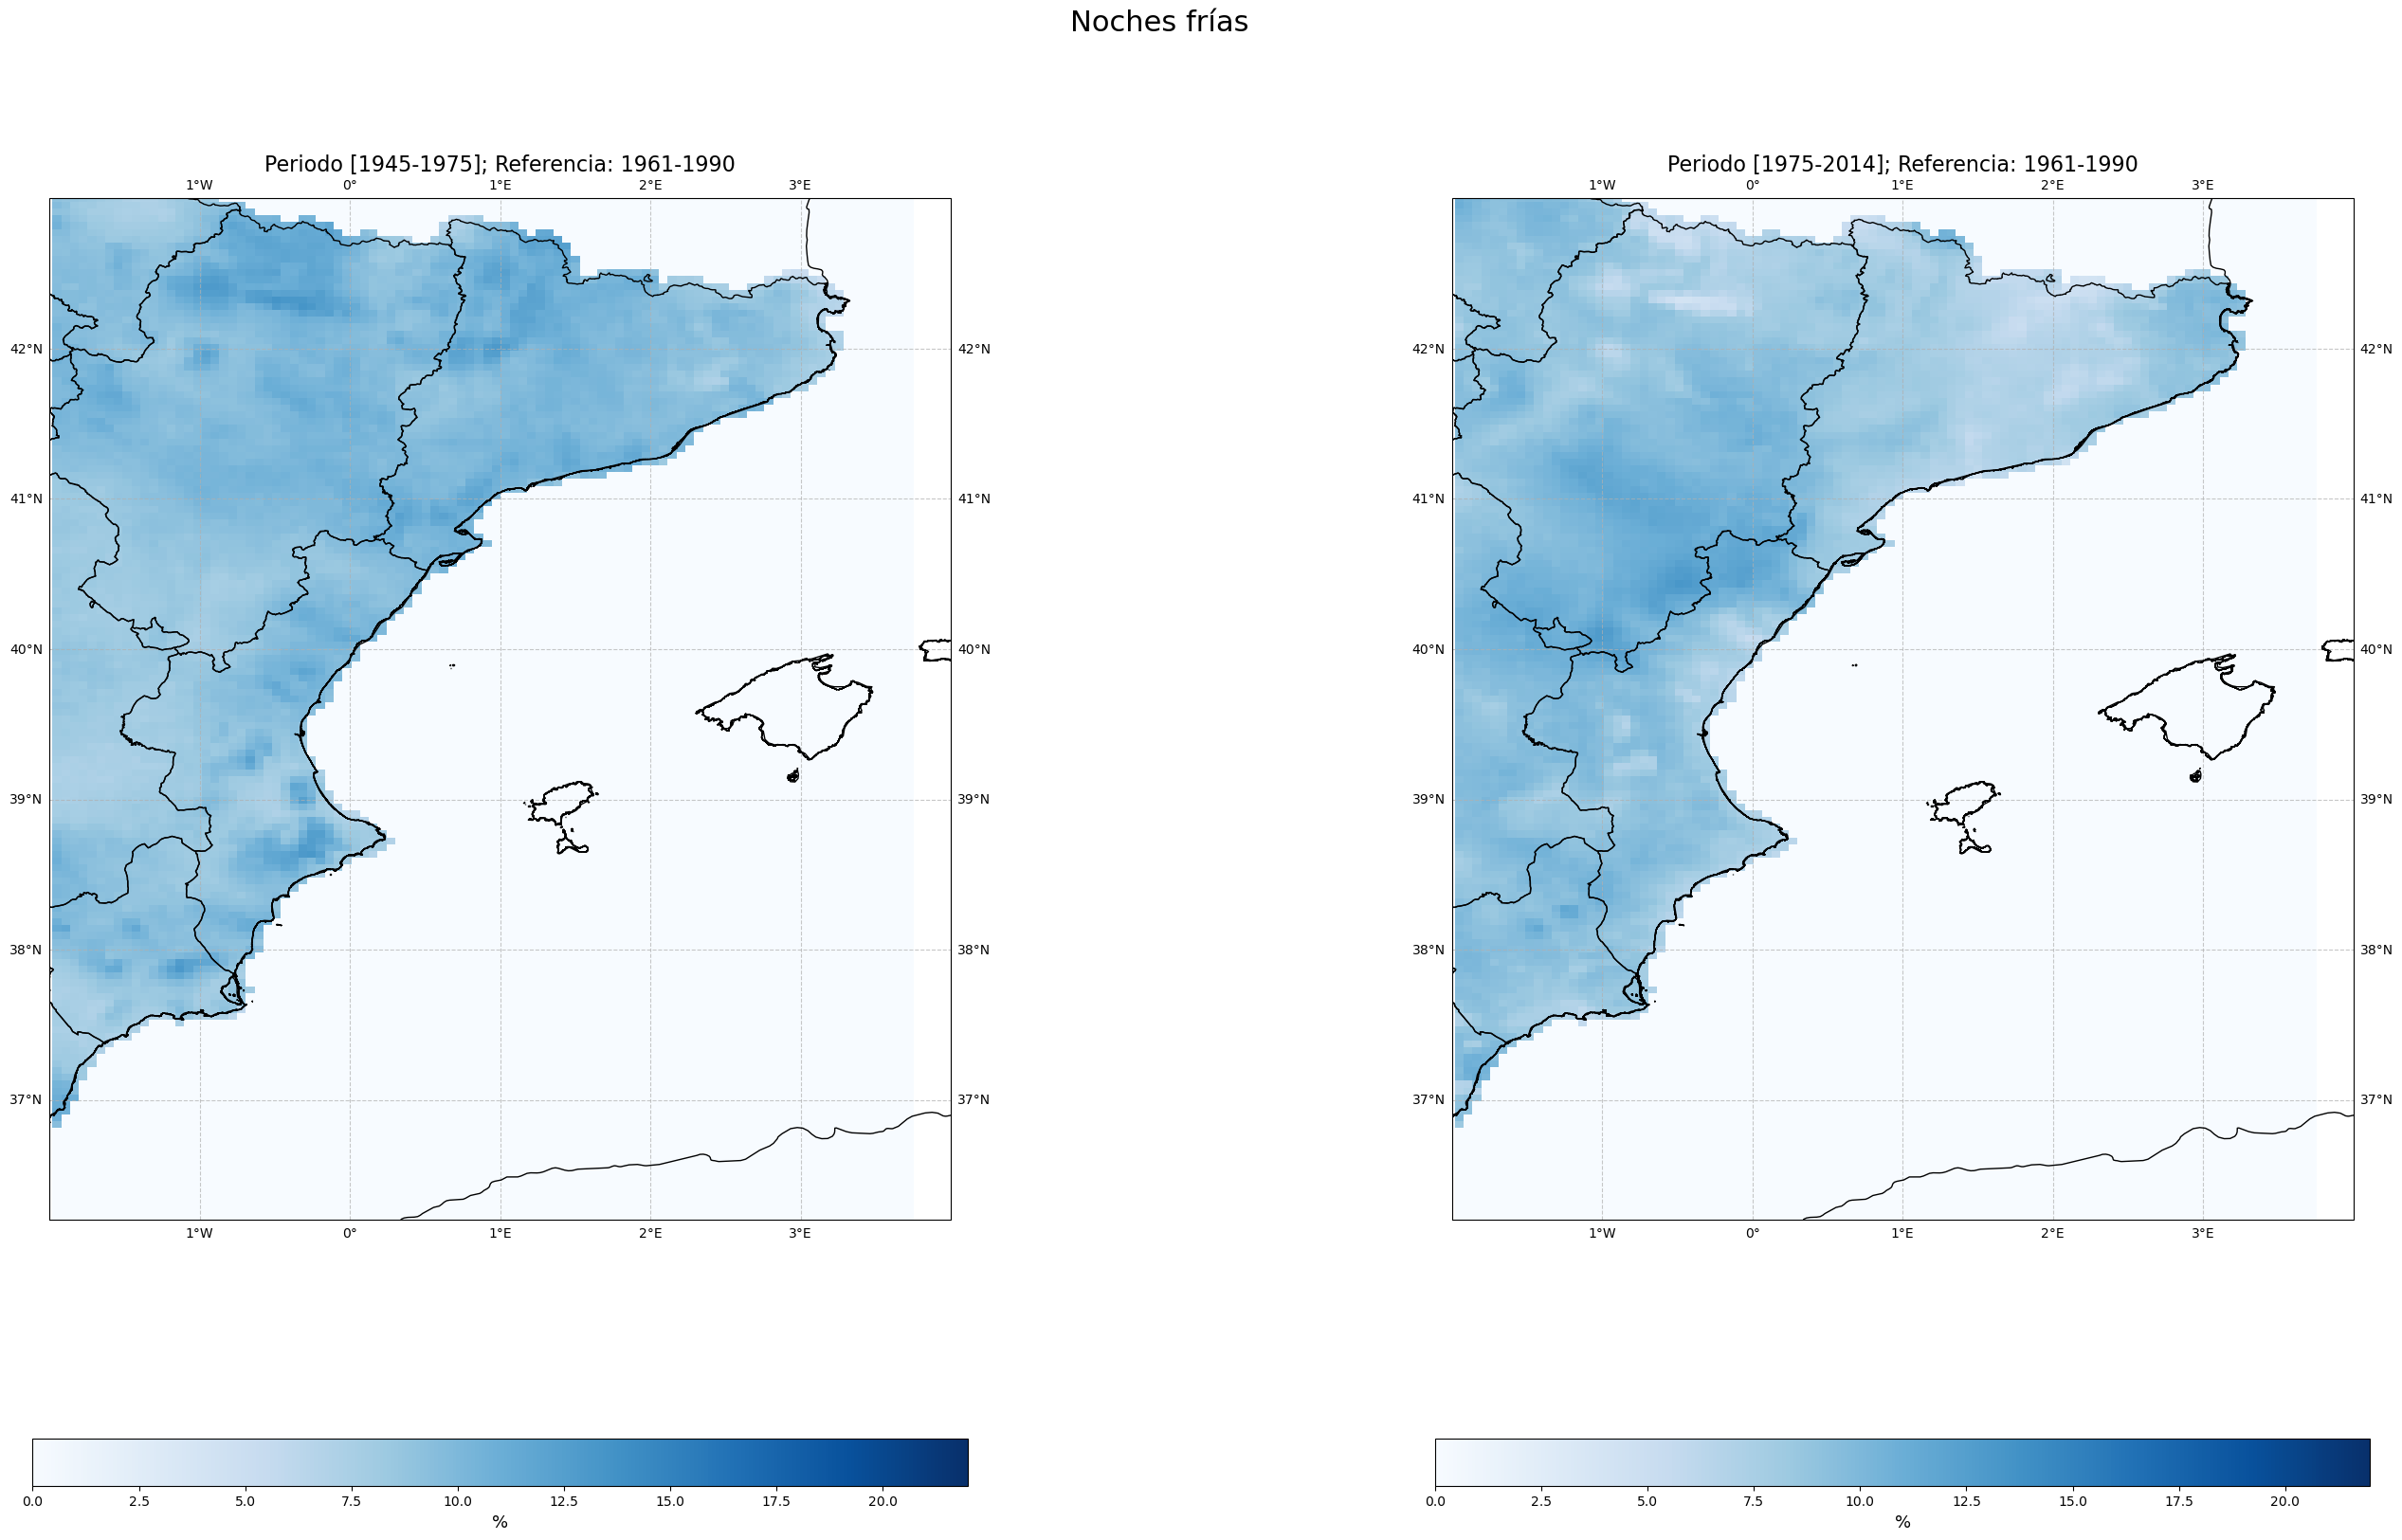

In [15]:
fname = '/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())


fig, (ax,ax2) = plt.subplots(1,2,figsize=(35, 20))

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())

plt.suptitle('Días frios',size=22)
plt.title('Periodo [1945-1975]; Referencia: 1961-1990',size=16)
ax.coastlines(resolution='10m')#, linewidth=2)
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)
ax.set_extent([-2,4,36.2,43], ccrs.PlateCarree())
cmap = cm.get_cmap('Blues')
var = percent_cold_days_E[45:75].mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label='%',size=13)
cbar.ax.set_xlim(0, 22)

ax2=plt.subplot(1,2,2,projection=ccrs.PlateCarree())

plt.suptitle('Noches frías',size=22)
plt.title('Periodo [1975-2014]; Referencia: 1961-1990',size=16)
ax2.coastlines(resolution='10m')#, linewidth=2)
ax2.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax2.set_global() # added following an answer to my question
#ax.gridlines()
ax2.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)
ax2.set_extent([-2,4,36.2,43], ccrs.PlateCarree())
cmap = cm.get_cmap('Blues')
var = percent_cold_days_E[75:].mean(dim='time')
im = ax2.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())
cbar = fig.colorbar(im,ax=ax2,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label='%',size=13)
cbar.ax.set_xlim(0, 22)



## Comparación entre noches frías y días fríos

<xarray.DataArray ()>
array(34.53031486)
Coordinates:
    percentiles  int32 10
<xarray.DataArray ()>
array(75.29467232)
Coordinates:
    percentiles  int32 10


(-90.0, 90.0)

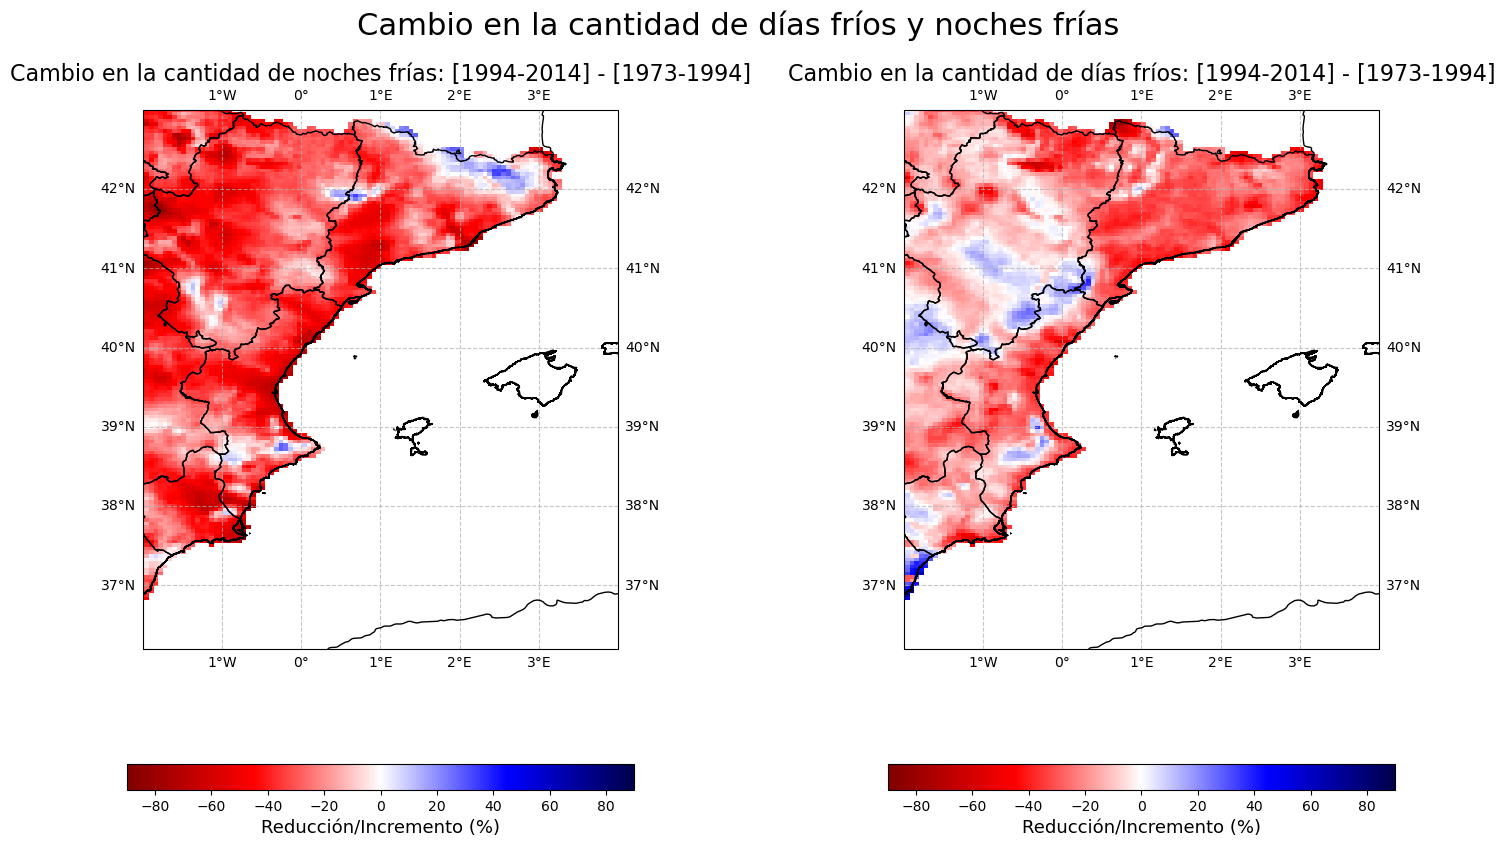

In [16]:
mapas = '/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(mapas).geometries())


fig, ax = plt.subplots(1,2, figsize=(18, 10))

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
plt.suptitle('Cambio en la cantidad de días fríos y noches frías ',size=22)
plt.title('Cambio en la cantidad de noches frías: [1994-2014] - [1973-1994]',size=16)

ax.coastlines(resolution='10m')#, linewidth=2)
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax.set_global() 
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)
ax.set_extent([-2,4,36.2,43], ccrs.PlateCarree())
cmap = cm.get_cmap('seismic_r')
vmin = -90
vmax = 90
var = (percent_cold_nights_E.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_days_E.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_days_E.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=u'Reducción/Incremento (%)',size=13)
cbar.ax.set_xlim(vmin, vmax)

ax1=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
plt.suptitle('Cambio en la cantidad de días fríos y noches frías',size=22)
plt.title('Cambio en la cantidad de días fríos: [1994-2014] - [1973-1994]',size=16)
ax1.coastlines(resolution='10m')#, linewidth=2)
ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax1.set_global() 
ax1.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)
ax1.set_extent([-2,4,36.2,43], ccrs.PlateCarree())
cmap = cm.get_cmap('seismic_r')
vmin = -90
vmax = 90
var = (percent_cold_days_E.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_days_E.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_days_E.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax1.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())
cbar = fig.colorbar(im,ax=ax1,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=u'Reducción/Incremento (%)',size=13)
cbar.ax.set_xlim(vmin, vmax)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<xarray.DataArray ()>
array(15.71497236)
Coordinates:
    percentiles  int32 ...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<xarray.DataArray ()>
array(20.84114396)
Coordinates:
    percentiles  int32 ...


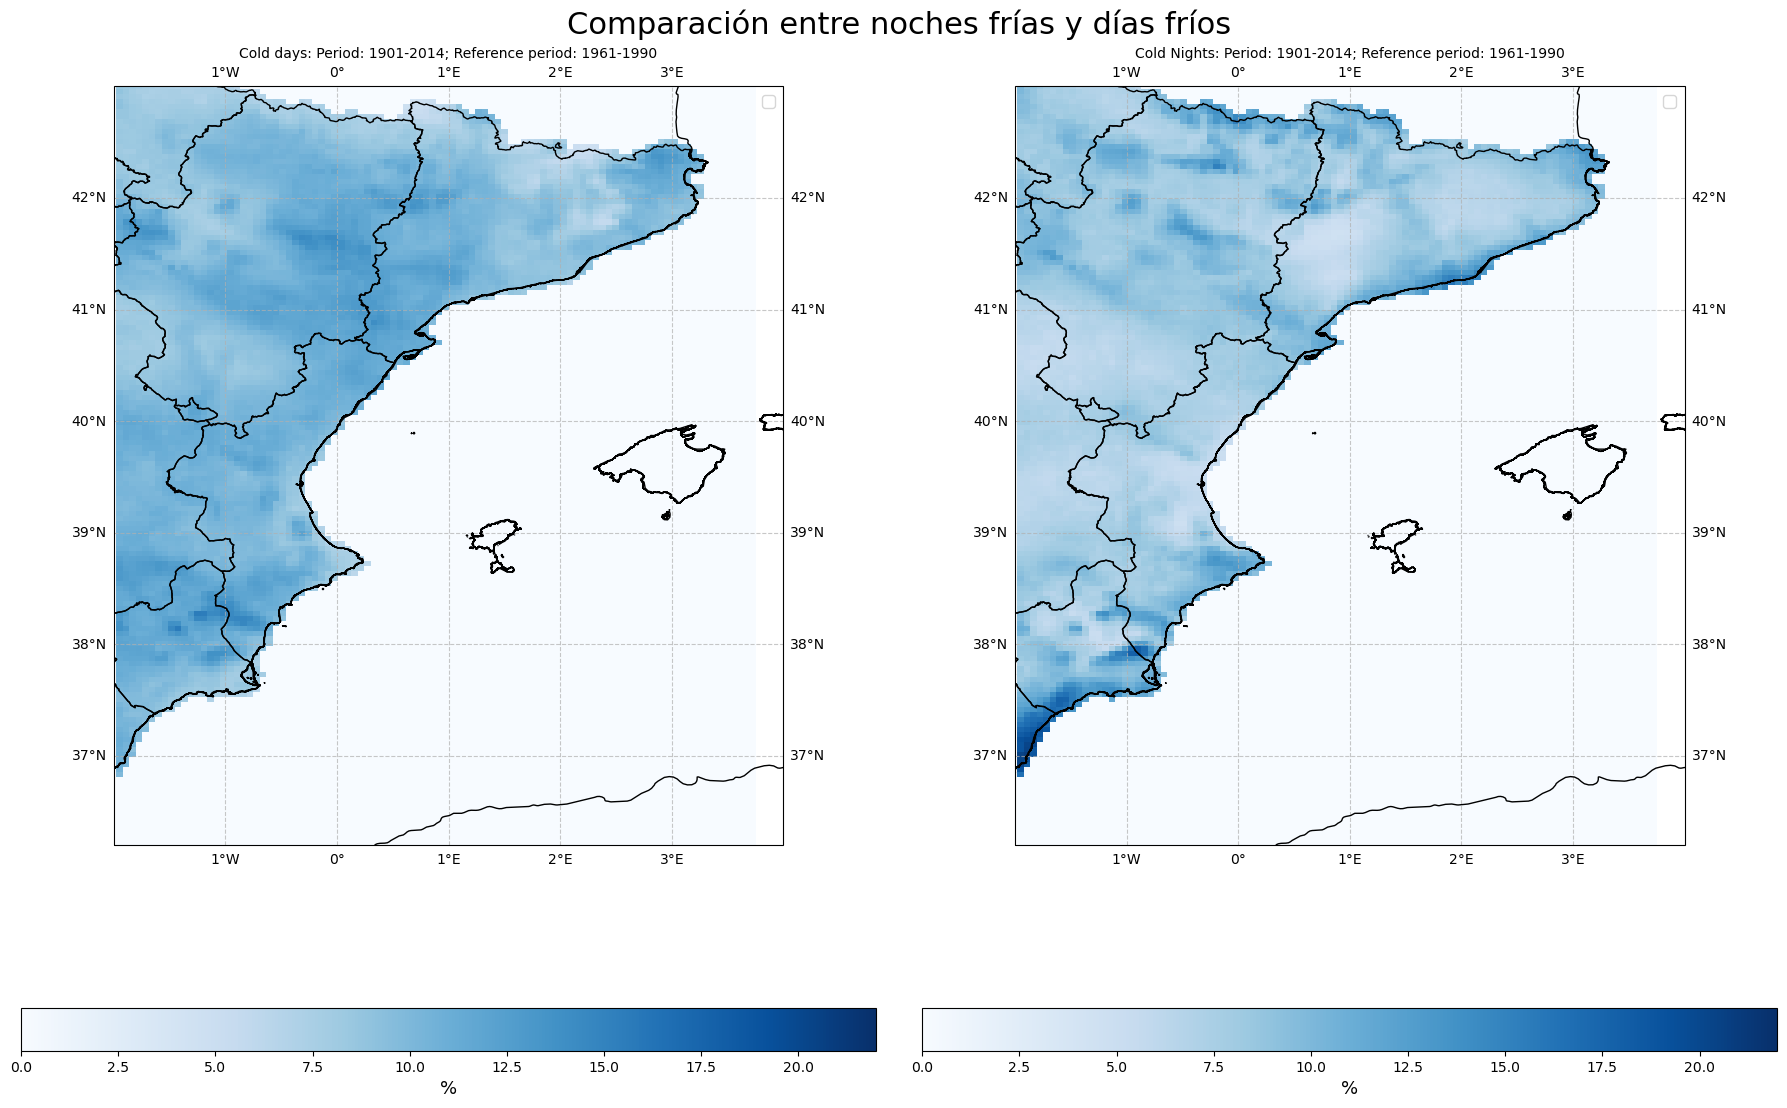

In [17]:
mapas = '/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(mapas).geometries())


fig, ax = plt.subplots(1,2,figsize=(20,12))

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
plt.suptitle('Comparación entre noches frías y días fríos',size=22)
plt.title('Cold days: Period: 1901-2014; Reference period: 1961-1990',size=10)
ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)
ax.set_extent([-2,4,36.2,43], ccrs.PlateCarree())
cmap = 'Blues'
var = percent_cold_days_E.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=f'%',size=13)
cbar.ax.set_xlim(0, 22)
ax.coastlines(resolution='10m')
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), 
                  edgecolor='black', facecolor='None', alpha=1)
ax.legend(prop={'size':12})
plt.tight_layout()


ax1=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
plt.suptitle('Comparación entre noches frías y días fríos',size=22)
plt.title('Cold Nights: Period: 1901-2014; Reference period: 1961-1990',size=10)
ax1.set_global() # added following an answer to my question
#ax.gridlines()
ax1.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)
ax1.set_extent([-2,4,36.2,43], ccrs.PlateCarree())
cmap = 'Blues'
var = percent_cold_nights_E.mean(dim='time')
im = ax1.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())
cbar = fig.colorbar(im,ax=ax1,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=f'%',size=13)
cbar.ax.set_xlim(0, 22)
ax1.coastlines(resolution='10m')
ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(), 
                  edgecolor='black', facecolor='None', alpha=1)
ax1.legend(prop={'size':12})
plt.tight_layout()

## Series temporales:

In [18]:
from matplotlib import style

def series_style():
    plt.style.use('seaborn') # Estilo general

    font = {'size'   : 14}
    plt.rc('font', **font) # Tamaño generico de fuentes
    parameters = {'xtick.labelsize':14,
                'ytick.labelsize':14,
                'axes.labelsize':14,
                'axes.labelweight':'bold',
                'axes.titleweight':'bold',
                'axes.titlesize':18,
                'legend.fontsize':15,
                'legend.frameon':True,
                'legend.facecolor':'w',
                'legend.title_fontsize':16,
                'ytick.major.size': 3.5,
                'ytick.major.width': 0.8,
                'xtick.major.size': 3.5,
                'xtick.major.width': 0.8,  
                'axes.linewidth':1,
                'axes.edgecolor':'grey',
                'xtick.color':'grey',
                'xtick.labelcolor':'k',
                'ytick.color':'grey',
                'ytick.labelcolor':'k'}
    plt.rcParams.update(parameters)

In [19]:
# series_style()
# fig,ax = plt.subplots(figsize = (16,6))
# años = percent_cold_nights_E['time.year']
# ax.plot(años,percent_cold_nights_E.mean(dim=['lon','lat']),color='purple',label='Este')
# ax.set_xlabel(u'Año')
# ax.set_ylabel(u'Porcentaje noches frías (%)')
# ax.set_title('Series temporales de noches frías (promedios regionales) [SALE MAL POR QUE HAY DATOS EN EL MAR]')
# plt.tight_layout()

In [20]:
display(tmin_p10_E.sel(lon='4',lat='39', method="nearest"))
display(percent_cold_nights_E)

<xarray.DataArray 'per' (dayofyear: 366)>
[366 values with dtype=float64]
Coordinates:
    lon          float64 3.724
    lat          float64 38.99
    percentiles  int32 ...
  * dayofyear    (dayofyear) int32 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Attributes:
    units:               °C
    long_name:           Minimum temperature
    climatology_bounds:  ['1961-01-01', '1990-12-31']
    window:              5
    alpha:               0.3333333333333333
    beta:                0.3333333333333333
    history:             [2022-11-17 00:34:29] per: percentile_doy(arr=tn, wi...

<xarray.DataArray (time: 114, lat: 152, lon: 98)>
array([[[12.328767, 10.136986, ...,  0.      ,  0.      ],
        [12.054795, 10.684932, ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ]],

       [[ 9.589041,  8.493151, ...,  0.      ,  0.      ],
        [ 9.589041,  8.219178, ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ]],

       ...,

       [[ 8.219178,  7.671233, ...,  0.      ,  0.      ],
        [ 8.219178,  7.39726 , ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ]],

       [[ 1.09589 ,  1.09589 , ...,  0.      ,  0.      ],
        [ 1.09589 ,  1.369863, ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ]]])
Coordinates:
  * lon          (lon) float64 -1.951 -1.892 -1.834 -1.775 ... 3.607 3.665 3.724
  * lat          (lat) float64 43.0 42.95 42.91 42.86 ... 36.34 36.29 36.25 36.2
    percentiles  int32 ...
  * time         (time) datetime64[ns] 1901-01-01 1902-01-01 ... 2014-01-01

Definición de la función que corrige la serie para que no tenga en cuenta los valores nan del oceano

In [21]:
def correct_series(percent,tmin=tmin):
    tminR = tmin.sel(lat=slice(float(np.nanmax(percent.lat)),float(np.min(percent.lat))),lon=slice(float(np.min(percent.lon)),float(np.max(percent.lon))),Time=slice('1901','2014'))
    tminR_year = tminR.sel(Time=((tminR.Time.dt.month == 6) & (tminR.Time.dt.day == 1)))
    #tminR_year = tminR.groupby('Time.year').max('Time')
    corr_R = np.where(np.isnan(tminR_year),np.nan,percent)
    return np.nanmean(corr_R,axis=(1,2))

In [22]:
corr_E = correct_series(percent_cold_nights_E)
corr_E_dias= correct_series(percent_cold_days_E)

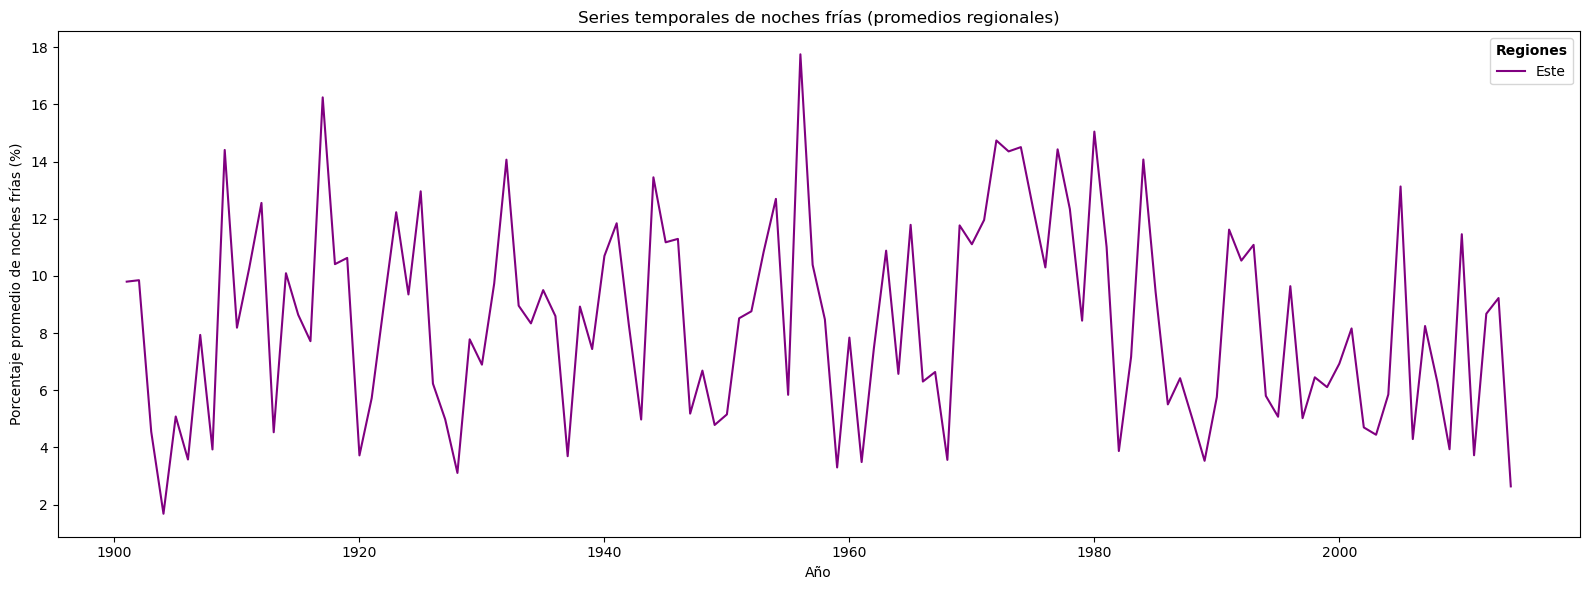

In [23]:
fig,ax = plt.subplots(figsize = (16,6))
años = percent_cold_nights_E['time.year']
ax.plot(años,corr_E,color='purple',label='Este')

ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(u'Año')
ax.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax.set_title('Series temporales de noches frías')
plt.tight_layout()

---

# Región este

---

In [24]:
lat_E = [36.2,43]
lon_E = [-2,4]
tminE = tmin.sel(lon=slice(lon_E[0],lon_E[1]),lat=slice(lat_E[1],lat_E[0]))
tmaxE= tmax.sel(lon=slice(lon_E[0],lon_E[1]),lat=slice(lat_E[1],lat_E[0]))

In [25]:
try: 
    tmin_p10_E = xr.open_dataarray('/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/outs/tmin_p10_E.nc')
    percent_cold_nights_E = xr.open_dataarray('/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/outs/percent_cold_nights_E.nc')
    print('Leido de outs')
except:
    tmin_p10_E, percent_cold_nights_E = cold_nights_xclim(tmin.sel(lat=slice(43,36.2),lon=slice(-2,4)),['1901','2014'])
    tmin_p10_E.to_netcdf('/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/outs/tmin_p10_E.nc')
    percent_cold_nights_E.to_netcdf('/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/outs/percent_cold_nights_E.nc')

Leido de outs


In [26]:
try: 
    tmax_p10_E =xr.open_dataarray('/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/outs/tmax_p10_E.nc')
    percent_cold_days_E = xr.open_dataarray('/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/outs/percent_cold_days_E.nc')
    print('Leido de outs')
except:
    tmax_p10_E, percent_cold_days_E = cold_nights_xclim(tmax.sel(lat=slice(43,36.2),lon=slice(-2,4)),['1901','2014'])
    tmax_p10_E.to_netcdf('/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/outs/tmax_p10_E.nc')
    percent_cold_days_E.to_netcdf('/Users/barbo/OneDrive/Escritorio/Analisis de datos/pract cold nights/outs/percent_cold_days_E.nc')

Leido de outs


# AJUSTE GEV Y GPD Y VALORES DE RETORNO

In [27]:
def nor(mu,sigma,x):
    #Nota: también podrías usar la función norm.pdf(x,k) del módulo stats del paquete scipy
    N=1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
    return N

def GEV(x,c):
    #Función que calcula la función densidad de probabilidad de Generalized Extrem Value normalizada
    # con m = 0, s = 1
    #nota: también puedes usar g=stats.genextreme.pdf(x,-c)
    if ( abs(c) < 0.005 ) :
        g = np.exp(-np.exp(-x))*np.exp(-x)
    else:
        g = ( np.power( 1 + c * x , -1-1/c) ) * np.exp( - np.power(1 + c * x ,-1/c) )
    return g

def GEVms(x,c,m,s):
    #Función que calcula la función de densidad de probabilidad Generalizada Extreme Value sin normalizar
    y = ( x - m ) / s
    if ( abs(c) < 0.005 ) :
        g = ( np.exp(-np.exp(-y))*np.exp(-y) ) / s
    else:
        g = ( np.power( 1 + c * y , -1-1/c) ) * np.exp( - np.power(1 + c * y ,-1/c) ) / s
    return g

def GPDs(y,c,s):
    #Función que calcula la función de densidad de probabilidad de Pareto Generalizada 
    if (abs(c)<0.0001):
        h = np.exp(-y/s)*(1/s)
    else:
        h = (1/s) * ( 1 + c * y / s) ** (-1-1/c)
    h[y<=0]=0
    return h

def MLE_GEV(c,m,s,x):
    #Función que calcula la función likelihood sobre GEV con 
    #los parámetros de entrada c,m,s
    #y la muestra de datos x
    if ( (s < 0) | np.any(1 + c * (x-m)/s ) < 0):
        sal=1e7
    else:            
        if (abs(c) > 0.00001 ):
            t = (1 + c * (x-m)/s )**(-1/c)
        else :
            t = np.exp(-(x-m)/s)
        f = - np.log(s) + (c +1)*np.log(t) -t
        sal = f.sum()
    return -sal


def returnLevel(p, c,m,s):
    if (abs(c) > 0.00001 ):
        zp = m - ( s / c ) * ( 1 - ( - np.log( 1 - p ) ) ** ( - c ))
    else :
        zp = m - s * np.log( - np.log( 1 - p ) )
    return zp


def densityPlotGEV(ax,x,c,m,s):
    n, bins, dummy = ax.hist(x,density=True,label='Empirica')
    x1, x2 = 2*bins[0] - bins[1], 2* bins[-1] - bins[-2]
    ax.set_xlim(x1,x2)
    x_x = np.linspace(x1,x2,200)
    y_y = GEVms(x_x,c,m,s)
    ax.plot(x_x,y_y,'r',label='Ajuste')
    ax.legend()
    ax.grid()
    ax.set_ylabel('probabilidad f(z)')
    ax.set_xlabel('z')
    return

def probabilityPlot(ax,pExp,pTeor):
    ax.plot([0,1],[0,1])
    ax.plot(pExp,pTeor,'o')
    ax.set_ylabel('Model')
    ax.set_xlabel('Empirical')
    ax.set_title('Probability plot',fontsize=25)
    ax.grid()
    return

def quantilePlot(ax,xTeor,xSort):
    xTeor = -xTeor
    xSort = -xSort
    ax.plot([xSort[0],xSort[-1]],[xSort[0],xSort[-1]])
    ax.plot(xTeor,xSort,'o')
    ax.set_ylabel('Model')
    ax.set_xlabel('Empirical')
    ax.set_title('Quantile plot',fontsize=25)
    ax.grid()
    return

def returnPlot(ax,p,zp,pExp,xSort):
    ax.semilogx(1/p,-zp)
    ax.grid()
    ax.set_xlim(1e-1,1e3)
    ax.semilogx(1/pExp,-xSort,'o')
    ax.set_title('Return level plot',fontsize=25)
    ax.set_xlabel('Return period (years)')
    ax.set_ylabel('Return level')
    return
    
def diagnosticsGEV(x,c,m,s):
    y = (x-m)/s
    ySort = np.sort(y)
    pExp = np.arange(1,ySort.size+1,1)/(ySort.size+1)
    pTeor = stats.genextreme.cdf(ySort,-c)
    xSort = np.sort(x)
    pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
    pExpinv = np.arange(xSort.size+1,1,-1)/(xSort.size+1)
    xTeor = returnLevel(1-pExp, c,m,s)    
    p = np.logspace(-2, -1e-2, 100)
    zp=returnLevel(p,c,m,s)
    fig, ax = plt.subplots(2, 2, figsize=(14,10))
    probabilityPlot(ax[0,0],pExp,pTeor)
    quantilePlot(ax[0,1],xTeor,xSort)
    returnPlot(ax[1,0],p,zp,pExpinv,xSort)
    densityPlotGEV(ax[1,1],x,c,m,s)
    fig.suptitle('Diagnostics',weight='bold',fontsize=25)
    
    return 

def diagnosticsGPD(x,c,m,s,numYears,invert=False):
    fig, ax = plt.subplots(2, 2, figsize=(20,15))
    fig.suptitle('Diagnostics',weight='bold',fontsize=18)
    xSort = np.sort(x)
    pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
    pExpinv = np.arange(xSort.size+1,1,-1)/(xSort.size+1)
    rv = stats.genpareto(c,m,s)
    pTeor = rv.cdf(xSort)
    xTeor = rv.ppf(pExp)
    fac = x.size / numYears
    p = np.logspace(-4, 2 , 100)
    zp = rv.ppf(1-p)
    fac = x.size / numYears
    returnPlot(ax[1,0],p*fac,zp,pExpinv*fac,xSort)
    probabilityPlot(ax[0,0],pExp,pTeor)
    quantilePlot(ax[0,1],xTeor,xSort)
    densityPlotGPD(ax[1,1],x,c,m,s)
    fig.tight_layout
    return (fig,ax)

def densityPlotGPD(ax,x,c,m,s):
    n, bins, dummy = ax.hist(-x,density=True,label='Empirica')
    x1, x2 = 2*bins[0] - bins[1], 2* bins[-1] - bins[-2]
    ax.set_xlim(x1,x2)
    x_x = np.linspace(x1,x2,200)
    y_y = stats.genpareto.pdf(-x_x,c,m,s)
    ax.plot(x_x,y_y,'r',linewidth = 4, label='Ajuste')
    ax.legend()
    ax.grid()
    ax.set_ylabel('probabilidad h(x)')
    ax.set_xlabel('x')
    ax.set_title('Density plot',fontsize=25)
    return
  

def readDataFrame(stationName):
    url = 'isd-history.csv'
    c=pd.read_csv(url)

    #Seleccionamos los años de inicio y final de lectura
    yearInit = 1973
    yearEnd = 2020

    #Construimos el código que necesitamos para bajar los datos de la estación:
    station=str(c.loc[(c['STATION NAME']==stationName)]['USAF'].values[0]) + '-' + \
            str(c.loc[(c['STATION NAME']==stationName)]['WBAN'].values[0])
    print('Seleccionada la estacion ' + stationName + ' con código ' + station)

    #Definimos las columnas y el tipo de dato que va a tener el DataFrame donde vamos a alojar los datos de la estación
    colNames=['year','month','day','hour','temp','tempd','slp','windDir','windSpeed','cloud','pcp1h','pcp6h']
    dataType=['int','int','int','int','float','float','int','int','int','int','int','int',]

    #Definimos los límites de los caractéres donde están los datos en los archivos que vamos a leer 
    #(Esta información está en: https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt)
    limits=[(0,4),(5,7),(8,10),(11,13),(14,19),(20,25),(26,31),(32,37),(38,43),(44,49),(50,55),(56,61)]
    
    #Lectura de los datos:
    df=pd.DataFrame(columns=colNames)
    for iyr in range(yearInit, yearEnd, 1):
        fil='https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/'+str(iyr)+'/'+station +'-'+ str(iyr)+'.gz'
        data= pd.read_fwf(fil,sep=' ',compression='gzip',head=0,
                     names=colNames,colspecs=limits)
        df = df.append(data)

    #Cambio el tipo de dato (porque los lee como objetos str y queremos que sean numéricos)
    dictType={ colNames[i] : dataType[i] for i in range(12)}
    data = df.astype(dictType,copy=True)
    #Los datos missing son -9999 en la base de datos: cambiamos por NaN:
    data = data.replace(-9999,np.NaN)
    
    dataDailyMax = data.groupby(['year','month','day']).max().drop(['hour'],axis=1).reset_index()
    dataDailyMax['time'] = pd.to_datetime(dataDailyMax[['year','month','day']],yearfirst=True)
    dataDailyMax = dataDailyMax.set_index('time')
    dataDailyCum = data.groupby(['year','month','day']).sum().drop(['hour'],axis=1).reset_index()
    dataDailyCum['time'] = pd.to_datetime(dataDailyCum[['year','month','day']],yearfirst=True)
    dataDailyCum = dataDailyCum.set_index('time')
    dataDailyMean = data.groupby(['year','month','day']).mean().drop(['hour'],axis=1).reset_index()
    dataDailyMean['time'] = pd.to_datetime(dataDailyMean[['year','month','day']],yearfirst=True)
    dataDailyMean = dataDailyMean.set_index('time')
    return dataDailyMax

In [28]:
tminE_mean=tminE.mean(dim=['lat','lon'])
tminE_mean

<xarray.DataArray 'tn' (Time: 41638)>
array([ 1.8958957 ,  2.8440323 ,  0.14009644, ..., -1.4552621 ,
       -1.7252624 , -1.3024937 ], dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01

In [29]:
tmaxE_mean=tmaxE.mean(dim=['lat','lon'])
tmaxE_mean

<xarray.DataArray 'tx' (Time: 41638)>
array([10.321516 ,  9.553835 ,  8.02314  , ...,  6.9270773,  7.8969316,
       11.015056 ], dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01

c=-0.184
m=-8.988
s=2.085
u=-8.988
100yr-return value=5.099


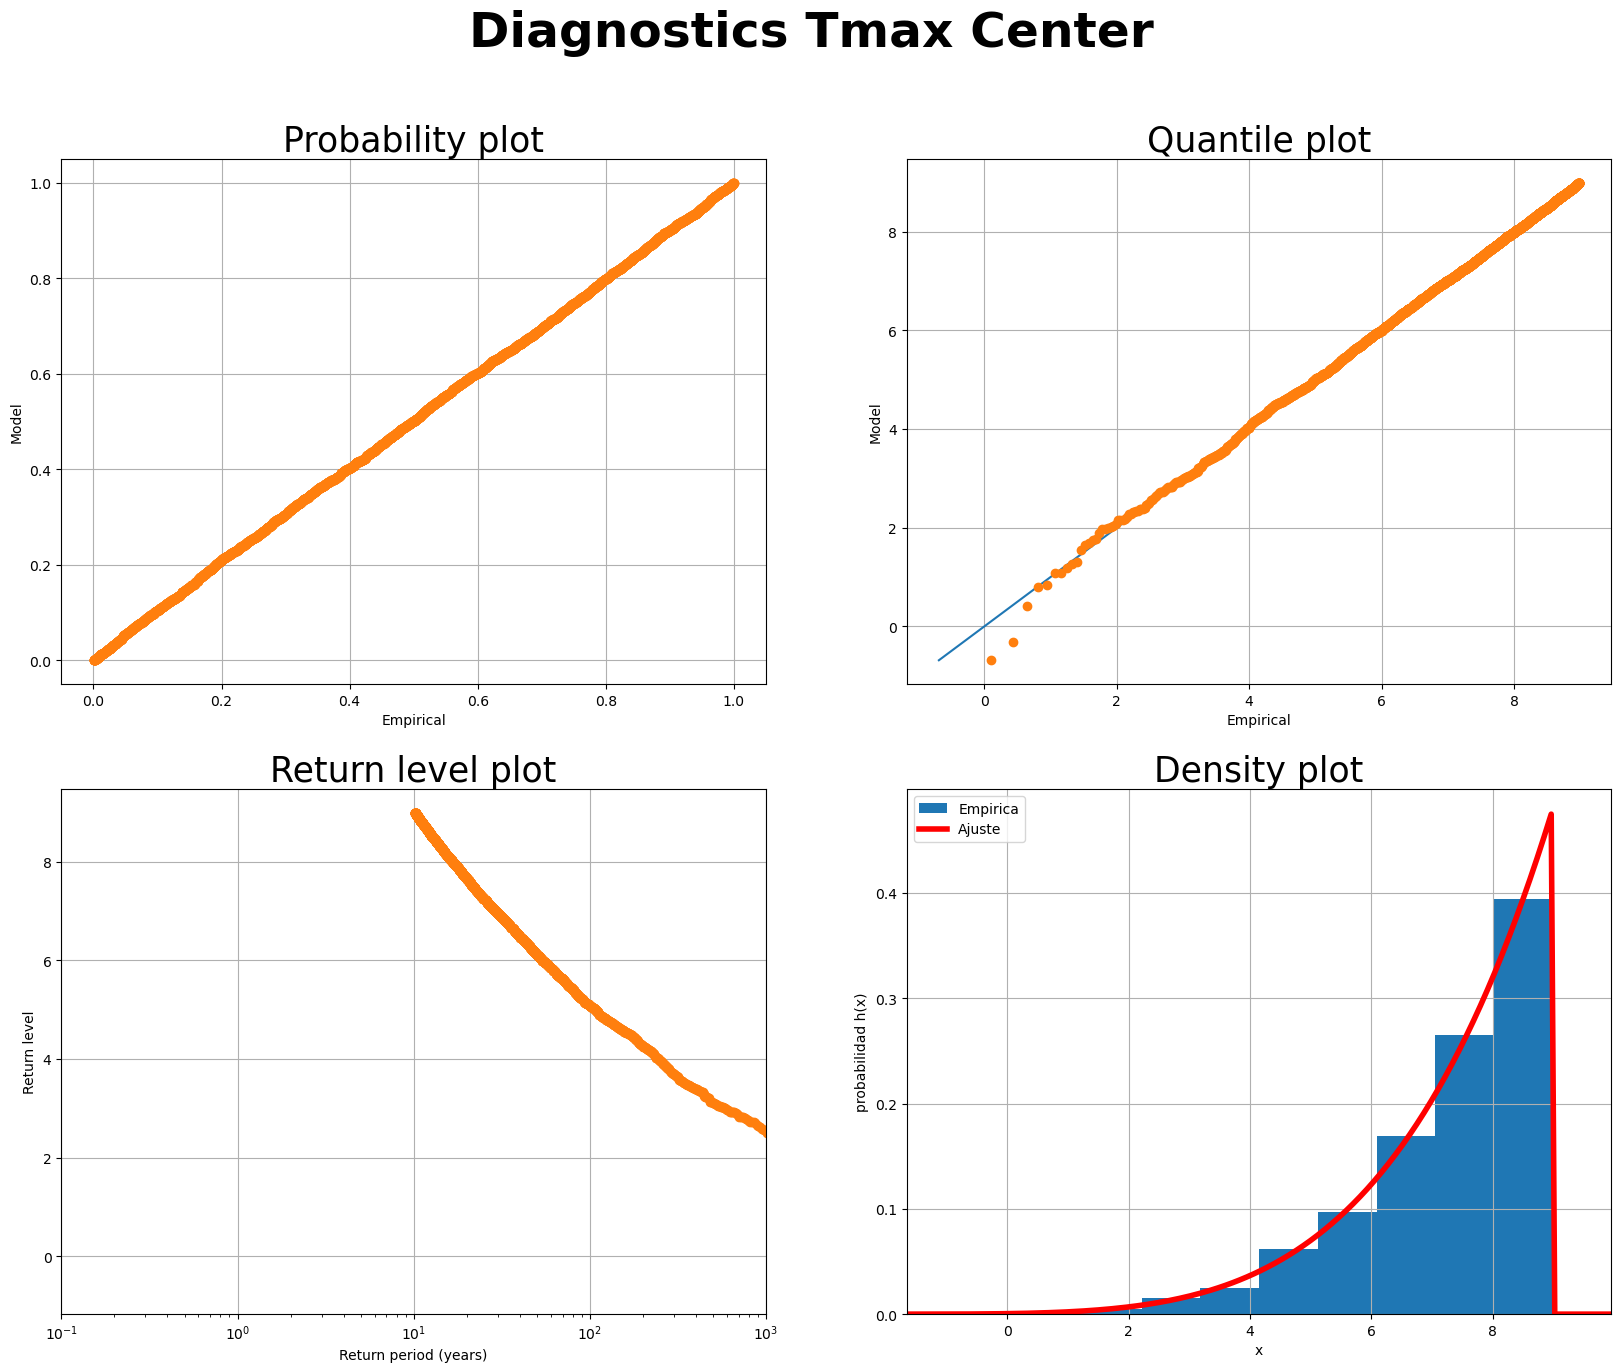

In [30]:
#Seleccion del umbral: cogeremos el percentil 10
x=-tmaxE_mean.copy()
xSort = np.sort(x)
pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
xLess= xSort[pExp<=.9]
u= xLess[-1] +.05
yExt = x[x>u].copy()  

#Ajuste usando herramienta de scipy:
c, m, s = stats.genpareto.fit(yExt,floc = u)

numYears=x.size
N = 100;
fac = yExt.size/numYears
rv = stats.genpareto(c,m,s)
zp = rv.ppf(1-1/N/fac)

#Diagnóstico:
fig,ax=diagnosticsGPD(yExt,c,m,s,numYears,True)
fig.suptitle('Diagnostics Tmax Este',weight='bold',fontsize=35)
print('c='+'%.3f'%(c))
print('m='+'%.3f'%(m))
print('s='+'%.3f'%(s))
print('u='+'%.3f'%(u))
print('100yr-return value='+'%.3f'%(-zp))

c=-0.110
m=-0.320
s=1.636
u=-0.320
100yr-return value=-2.977


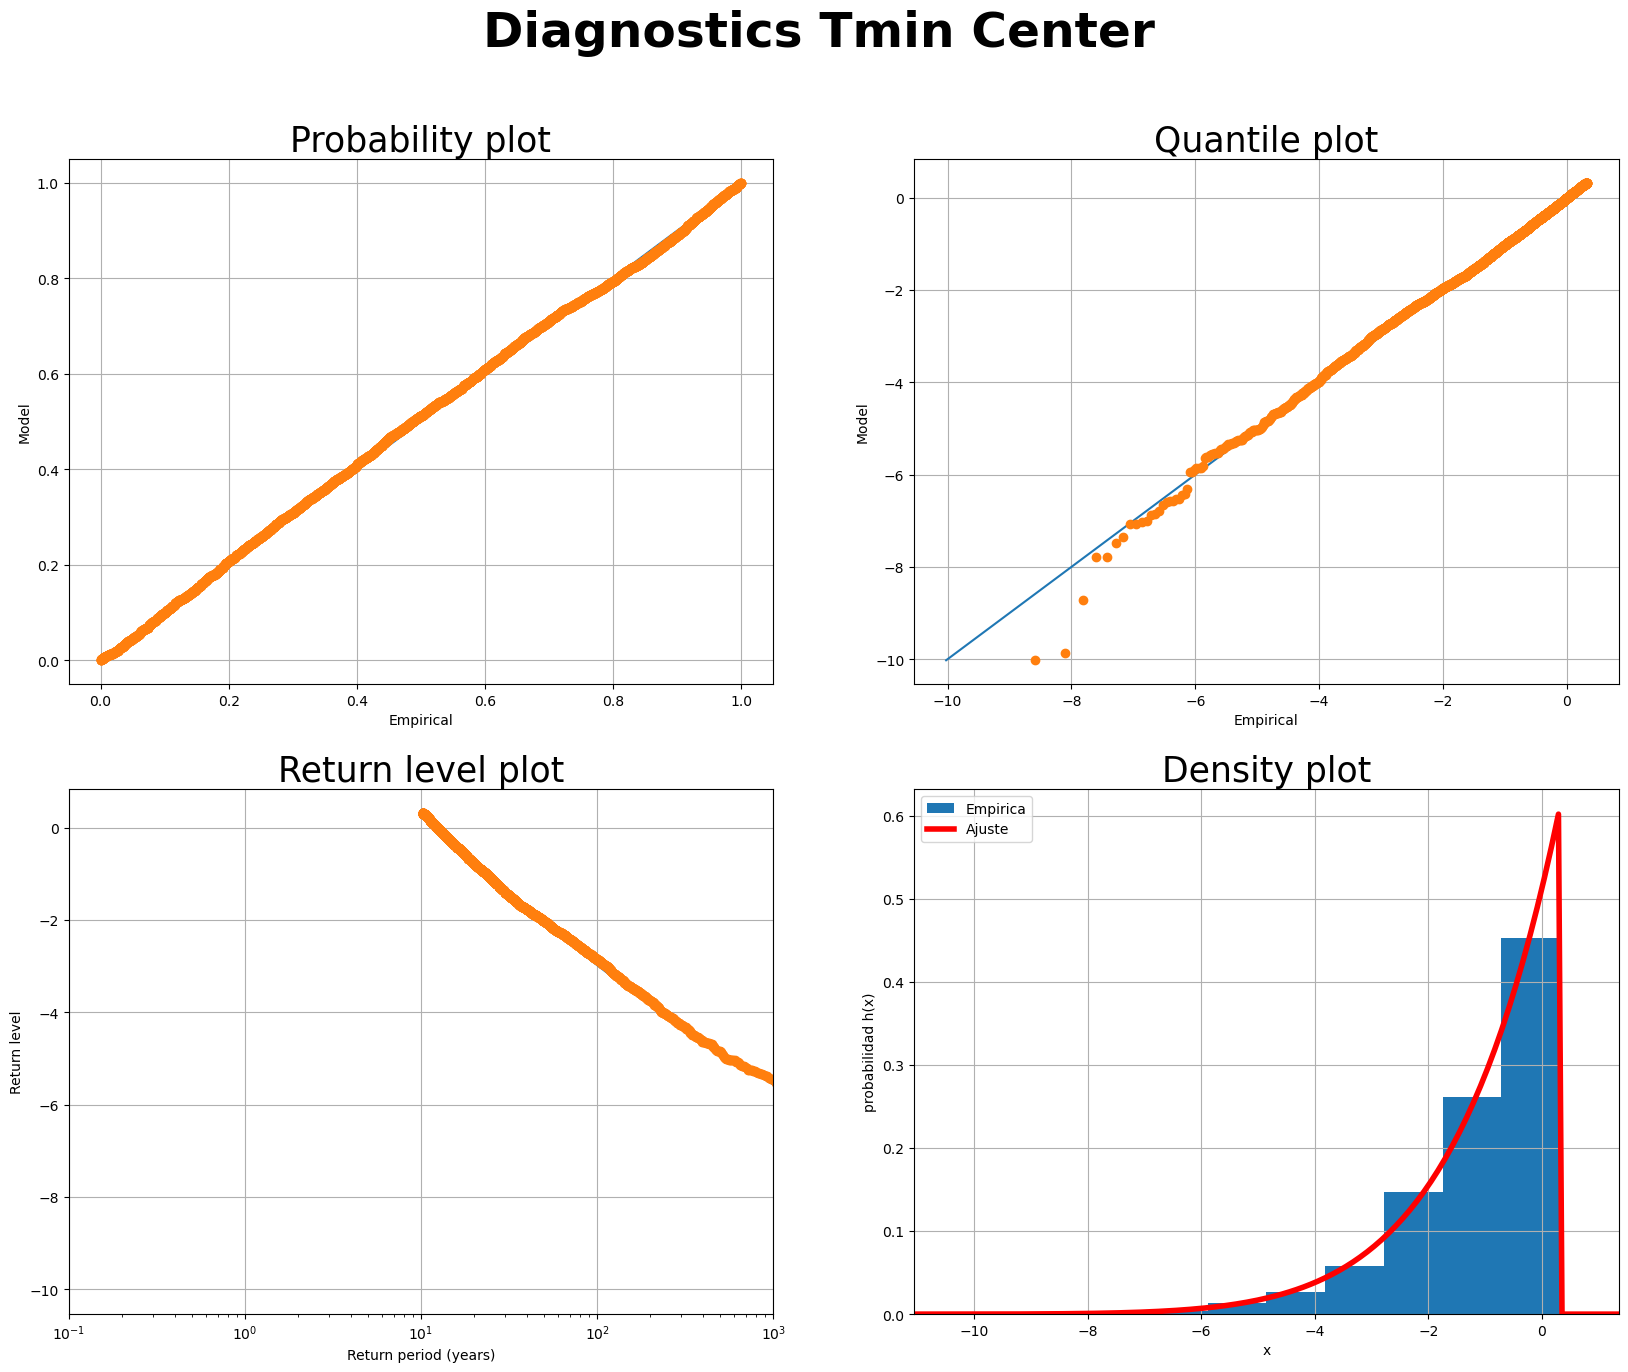

In [31]:
#Seleccion del umbral: cogeremos el percentil 10
x=-tminE_mean.copy()
xSort = np.sort(x)
pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
xLess= xSort[pExp<=.9]
u= xLess[-1] +.05
yExt = x[x>u].copy()  

#Ajuste usando herramienta de scipy:
c, m, s = stats.genpareto.fit(yExt,floc = u)

numYears=x.size
N = 100;
fac = yExt.size/numYears
rv = stats.genpareto(c,m,s)
zp = rv.ppf(1-1/N/fac)

#Diagnóstico:
fig,ax=diagnosticsGPD(yExt,c,m,s,numYears,True)
fig.suptitle('Diagnostics Tmin Este',weight='bold',fontsize=35)
print('c='+'%.3f'%(c))
print('m='+'%.3f'%(m))
print('s='+'%.3f'%(s))
print('u='+'%.3f'%(u))
print('100yr-return value='+'%.3f'%(-zp))

# Periodogramas

In [32]:
def runningMean(x,T):
    y = x.copy() * np.NaN
    N = x.size
    ini = int((T-1)/2)
    fin = int(T/2)
    for i in range(ini,N-fin):
        y[i] = np.mean(x[i-ini:i+fin+1])
    return y


def espectroArmonico(x,At):
    x = np.squeeze(np.array(x))
    N = x.size 
    xm = x.mean()
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    jvec=np.arange(1,N+1)
    a = np.zeros(Nmax)
    b = np.zeros(Nmax)
    xa = x-xm
    fac = 2*np.pi*jvec/N
    for k in range(Nmax):
        a[k] = 2 / N * np.sum( np.matmul(xa,np.cos(fac*(k+1)) ))
        b[k] = 2 / N * np.sum( np.matmul(xa,np.sin(fac*(k+1)) ))
    if (N%2)==0: b[Nmax-1]=0
    kvec = np.arange(1,Nmax+1)
    # Habría que dividir entre 4, pero como sólo damos la parte positiva, para
    # que la suma de G nos aporte la varianza dividimos sólo entre 2
    G = ( a**2+b**2 ) / 2
    f = kvec/(N*At)
    return f,G

def espectroFFT(x,At):
    x = np.squeeze(np.array(x))
    N=x.size
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    y = fft(x)
    ap = 2/N*np.real(y[1:Nmax+1])
    bp =  - 2/N*np.imag(y[1:Nmax+1])
    xm = np.mean(x)
    kvec = np.arange(1,Nmax+1)
    # Habría que dividir entre 4, pero como sólo damos la parte positiva, para
    # que la suma de G nos aporte la varianza dividimos sólo entre 2
    G = ( ap**2+bp**2 ) / 2
    f = kvec/(N*At)
    return f,G

def redSpectra(a,s2):
    f = np.arange(.0,.51,.01)
    N = f.size
    G = (s2*(1-a**2))/(1+a**2-2*a*np.cos(2*np.pi*f))
    #Hay que multiplicar por 2 porque sólo sacamos la parte positiva
    return f,2*G

def ajusteArmonico(x,numArm):
    x = np.squeeze(np.array(x))
    N = x.size 
    xm = x.mean()
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    jvec=np.arange(1,N+1)
    a = np.zeros(Nmax)
    b = np.zeros(Nmax)
    xa = x-xm
    fac = 2*np.pi*jvec/N
    for k in range(Nmax):
        a[k] = 2 / N * np.sum( np.matmul(xa,np.cos(fac*(k+1)) ))
        b[k] = 2 / N * np.sum( np.matmul(xa,np.sin(fac*(k+1)) ))
    if (N%2)==0: b[Nmax-1]=0
    kvec = np.arange(1,Nmax+1)
    xhat = np.zeros(N)
    n = np.min([numArm,Nmax])
    for j in range(N):
        xhat[j] =  xm + np.sum( a[:n] * np.cos (2*np.pi*kvec[:n]*(j+1)/N) + b[:n] *
                               np.sin (2*np.pi*kvec[:n]*(j+1)/N) )
    return xhat,a,b

def ajusteArmonicoFFT(x,numArm):
    x = np.squeeze(np.array(x))
    N=x.size
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    y = fft(x)
    ap = 2/N*np.real(y[1:Nmax+1])
    bp =  - 2/N*np.imag(y[1:Nmax+1])
    xm = np.mean(x)
    kvec = np.arange(1,Nmax+1)
    xhat = np.zeros(N)
    n = np.min([numArm+1,Nmax])
    for j in range(N):
        xhat[j] =  xm + np.sum( ap[:n] * np.cos (2*np.pi*kvec[:n]*(j)/N) + bp[:n] * 
                               np.sin (2*np.pi*kvec[:n]*(j)/N) )
    return xhat,ap,bp

def calculoAR1(x):
    xm = np.mean(x)
    N = x.size
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    sx = np.std(x, ddof=1)
    fac = np.sqrt((N-1)/(N-2)*(1-a**2))*sx
    AR1 = x * np.NaN
    rng = np.random.default_rng()
    Z = rng.normal(0,1,N)
    #También podéis generar el ruido blanco con stats de scipy
    #Z = stats.norm.rvs(size=N)
    AR1[0] = Z[0]
    for i in range(N-1):
        AR1[i+1] =  a * ( AR1[i] ) + fac * Z[i+1]
    return AR1 + xm


def calculoAutocov(x,nlag):
    cov = np.zeros([nlag+1])
    N = x.size
    xm = np.mean(x)
    ax = x-xm
    for t in range(nlag+1):
        cov[t] = np.sum(ax[:N-t]*ax[t:])/(N-1)
    return cov

def region(sst,lonmin, lonmax, latmin, latmax):
    reg = sst[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:].mean(axis=(1,2))
    nt = reg.size
    nm = 12
    ny = int(nt/nm)
    reg = reg.reshape(nm,ny,order='F')
    mreg = np.nanmean(reg,axis=1)
    anom = reg.copy()*np.NaN
    for i in range(ny):
        for j in range(nm):
            anom[j,i] = reg[j,i] - mreg[j]
    return anom

La varianza de la serie es  1.0
La integral del espectro es  1.0004752821611729
La varianza de la serie es  1.0
La integral del espectro es  1.0002119025014315


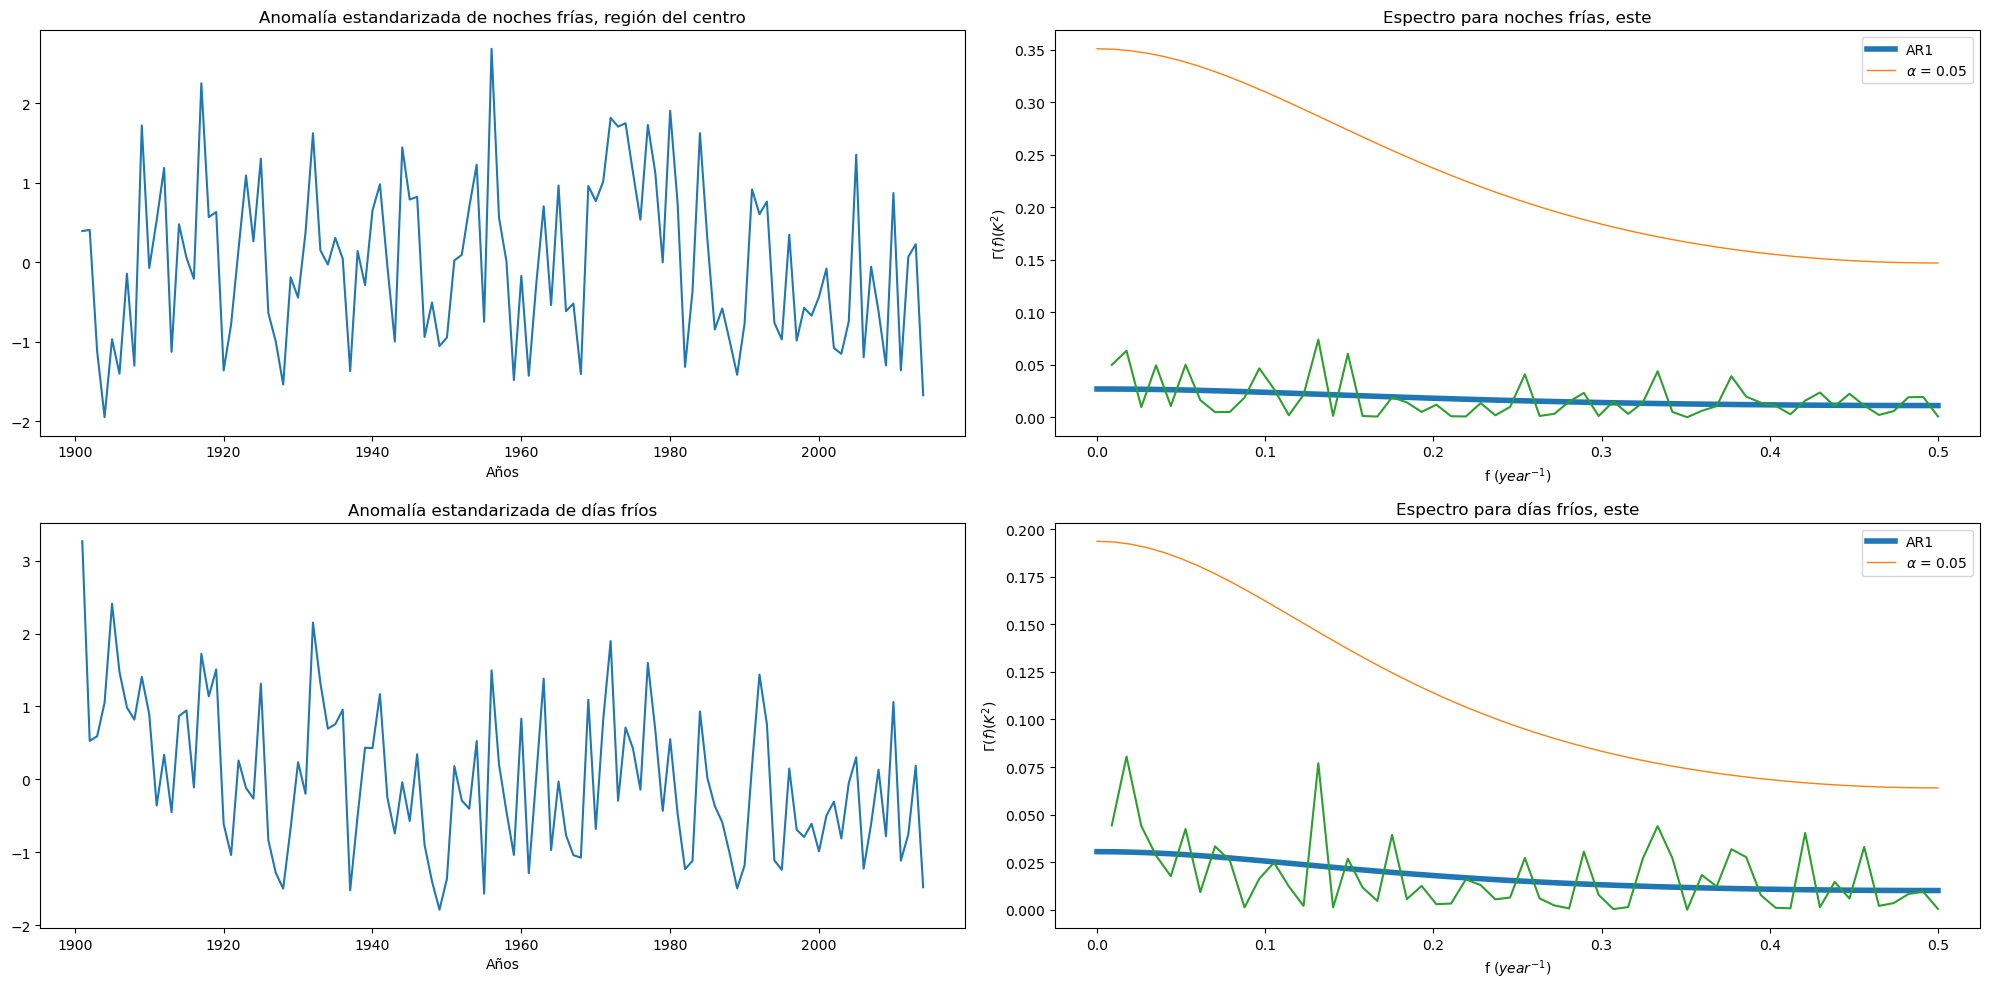

In [33]:
fig,ax=plt.subplots(2,2,figsize=(20,10))
eje_x=np.arange(1901,2014+1)
años=eje_x
################## DIAS FRIOS ##################
anomalia_std_noches_frias=(corr_E-np.mean(corr_E))/np.std(corr_E)

ax[0,0].plot(eje_x,anomalia_std_noches_frias)
ax[0,0].set_title('Anomalía estandarizada de noches frías, región del este')
ax[0,0].set_xlabel(u'Años')

ff,Gf = espectroFFT(x,1)

x = np.squeeze(np.array(anomalia_std_noches_frias))
#Veamos si los picos sobresalen lo suficiente:
alpha = 0.05
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
s2 = np.var(x)
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
f,G = redSpectra(a,s2)
ax[0,1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[0,1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = '+str(alpha))
a,s2,chi2
ax[0,1].legend()
ff,Gf = espectroFFT(x,1)
ax[0,1].plot(ff,Gf,label='fft')
ax[0,1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[0,1].set_xlabel(r'f ($year^{-1}$)')
ax[0,1].set_title('Espectro para noches frías, este')

print('La varianza de la serie es ',np.var(x))
print('La integral del espectro es ',sum(Gf))


################## NOCHES FRIAS ##################
anomalia_std_dias_frios=(corr_E_dias-np.mean(corr_E_dias))/np.std(corr_E_dias)
ax[1,0].plot(eje_x,anomalia_std_dias_frios)
ax[1,0].set_title('Anomalía estandarizada de días fríos')
ax[1,0].set_xlabel(u'Años')

x = np.squeeze(np.array(anomalia_std_dias_frios))
#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
s2 = np.var(x)
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
f,G = redSpectra(a,s2)
ax[1,1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1,1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = 0.05')
a,s2,chi2
ax[1,1].legend()
ff,Gf = espectroFFT(x,1)
ax[1,1].plot(ff,Gf,label='fft')
ax[1,1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1,1].set_xlabel(r'f ($year^{-1}$)')
ax[1,1].set_title('Espectro para días fríos, este')

print('La varianza de la serie es ',np.var(x))
print('La integral del espectro es ',sum(Gf))



fig.tight_layout()

In [34]:
lat_E = [36.2,43]
lon_E = [-2,4]

In [35]:
def correct_series(percent,tmin=tmin,freq='YS'):
    '''El objetivo de esta función es volver a colocar los np.nan en las posiciones del cuadrado de lat y lon donde 
    no tenemos datos. Al calcular el índice de extremos esos puntos han quedado con 0. Esto hace que al promediar esas
    dimensiones infraestimemos la media'''
    tmin = tmin.rename({'Time': 'time'})
    if freq=='YS':
        tminR = tmin.sel(lat=slice(float(np.nanmax(percent.lat)),float(np.min(percent.lat))),lon=slice(float(np.min(percent.lon)),float(np.max(percent.lon))),time=slice(str(int(np.min(percent.time.dt.year))),str(int(np.max(percent.time.dt.year)))))
        tminR_year = tminR.sel(time=((tminR.time.dt.month == 6) & (tminR.time.dt.day == 1)))
        corr_R = np.where(np.isnan(tminR_year),np.nan,percent)
        corr_R_x = xr.DataArray(corr_R,coords={'time': percent.time, 'y': percent.lat,'x': percent.lon},dims=['time','lat','lon'])
        result = corr_R_x.mean(dim=['lon','lat'])


    if freq=='MS':
        tminR = tmin.sel(lat=slice(float(np.nanmax(percent.lat)),float(np.min(percent.lat))),lon=slice(float(np.min(percent.lon)),float(np.max(percent.lon))),time=slice(str(int(np.min(percent.time.dt.year))),str(int(np.max(percent.time.dt.year)))))
        tminR_year = tminR.sel(time=(tminR.time.dt.day == 10))
        corr_R = np.where(np.isnan(tminR_year),np.nan,percent)
        corr_R_x = xr.DataArray(corr_R,coords={'time': percent.time, 'y': percent.lat,'x': percent.lon},dims=['time','lat','lon'])

        result = corr_R_x.mean(dim=['lon','lat'])

    return result

In [36]:
tmin_E = tmin.sel(lon=slice(-2,4),lat=slice(43,36.2))
tmin2_E = tmin_E.rename({'Time': 'time'})
tmin2_E.attrs['units'] = 'degC'

num_cold_nights_E_m = xr.open_dataarray('/Users/barbo/Desktop/descarga datos/percent_cold_nights_E_m_FULL.nc')

In [37]:
tmax_E = tmax.sel(lon=slice(-7,-1),lat=slice(42,38))
tmax2_E = tmax_E.rename({'Time': 'time'})
tmax2_E.attrs['units'] = 'degC'

num_cold_days_E_m = xr.open_dataarray('/Users/barbo/Desktop/descarga datos/percent_cold_days_E_m_FULL.nc')


In [38]:
percent_cold_nights_E_m = num_cold_nights_E_m/num_cold_nights_E_m.time.dt.days_in_month*100
percent_cold_days_E_m = num_cold_days_E_m/num_cold_days_E_m.time.dt.days_in_month*100

In [39]:
corr_days_E_mes = correct_series(percent_cold_days_E_m,freq='MS')
corr_nights_E_mes = correct_series(percent_cold_nights_E_m,freq='MS')

In [40]:
anom_E = (corr_days_E_mes.groupby('time.month')-corr_days_E_mes.groupby('time.month').mean('time'))#/(corr_O_monthly.groupby('time.month').std('time'))
anom_E_std = anom_E.groupby('time.month')/corr_days_E_mes.groupby('time.month').std('time')

In [41]:
anom_nights_E_std = (corr_nights_E_mes.groupby('time.month')-corr_nights_E_mes.groupby('time.month').mean('time')).groupby('time.month')/corr_nights_E_mes.groupby('time.month').std('time')
anom_nights_E_std

<xarray.DataArray (time: 1368)>
array([-0.54764361,  3.06015843,  0.34132624, ..., -0.94688552,
       -0.98487961, -0.61586847])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2014-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

La varianza de la serie es  1.0
La integral del espectro es  1.0000000000000004
La varianza de la serie es  0.9999999999999996
La integral del espectro es  0.9999999999999991


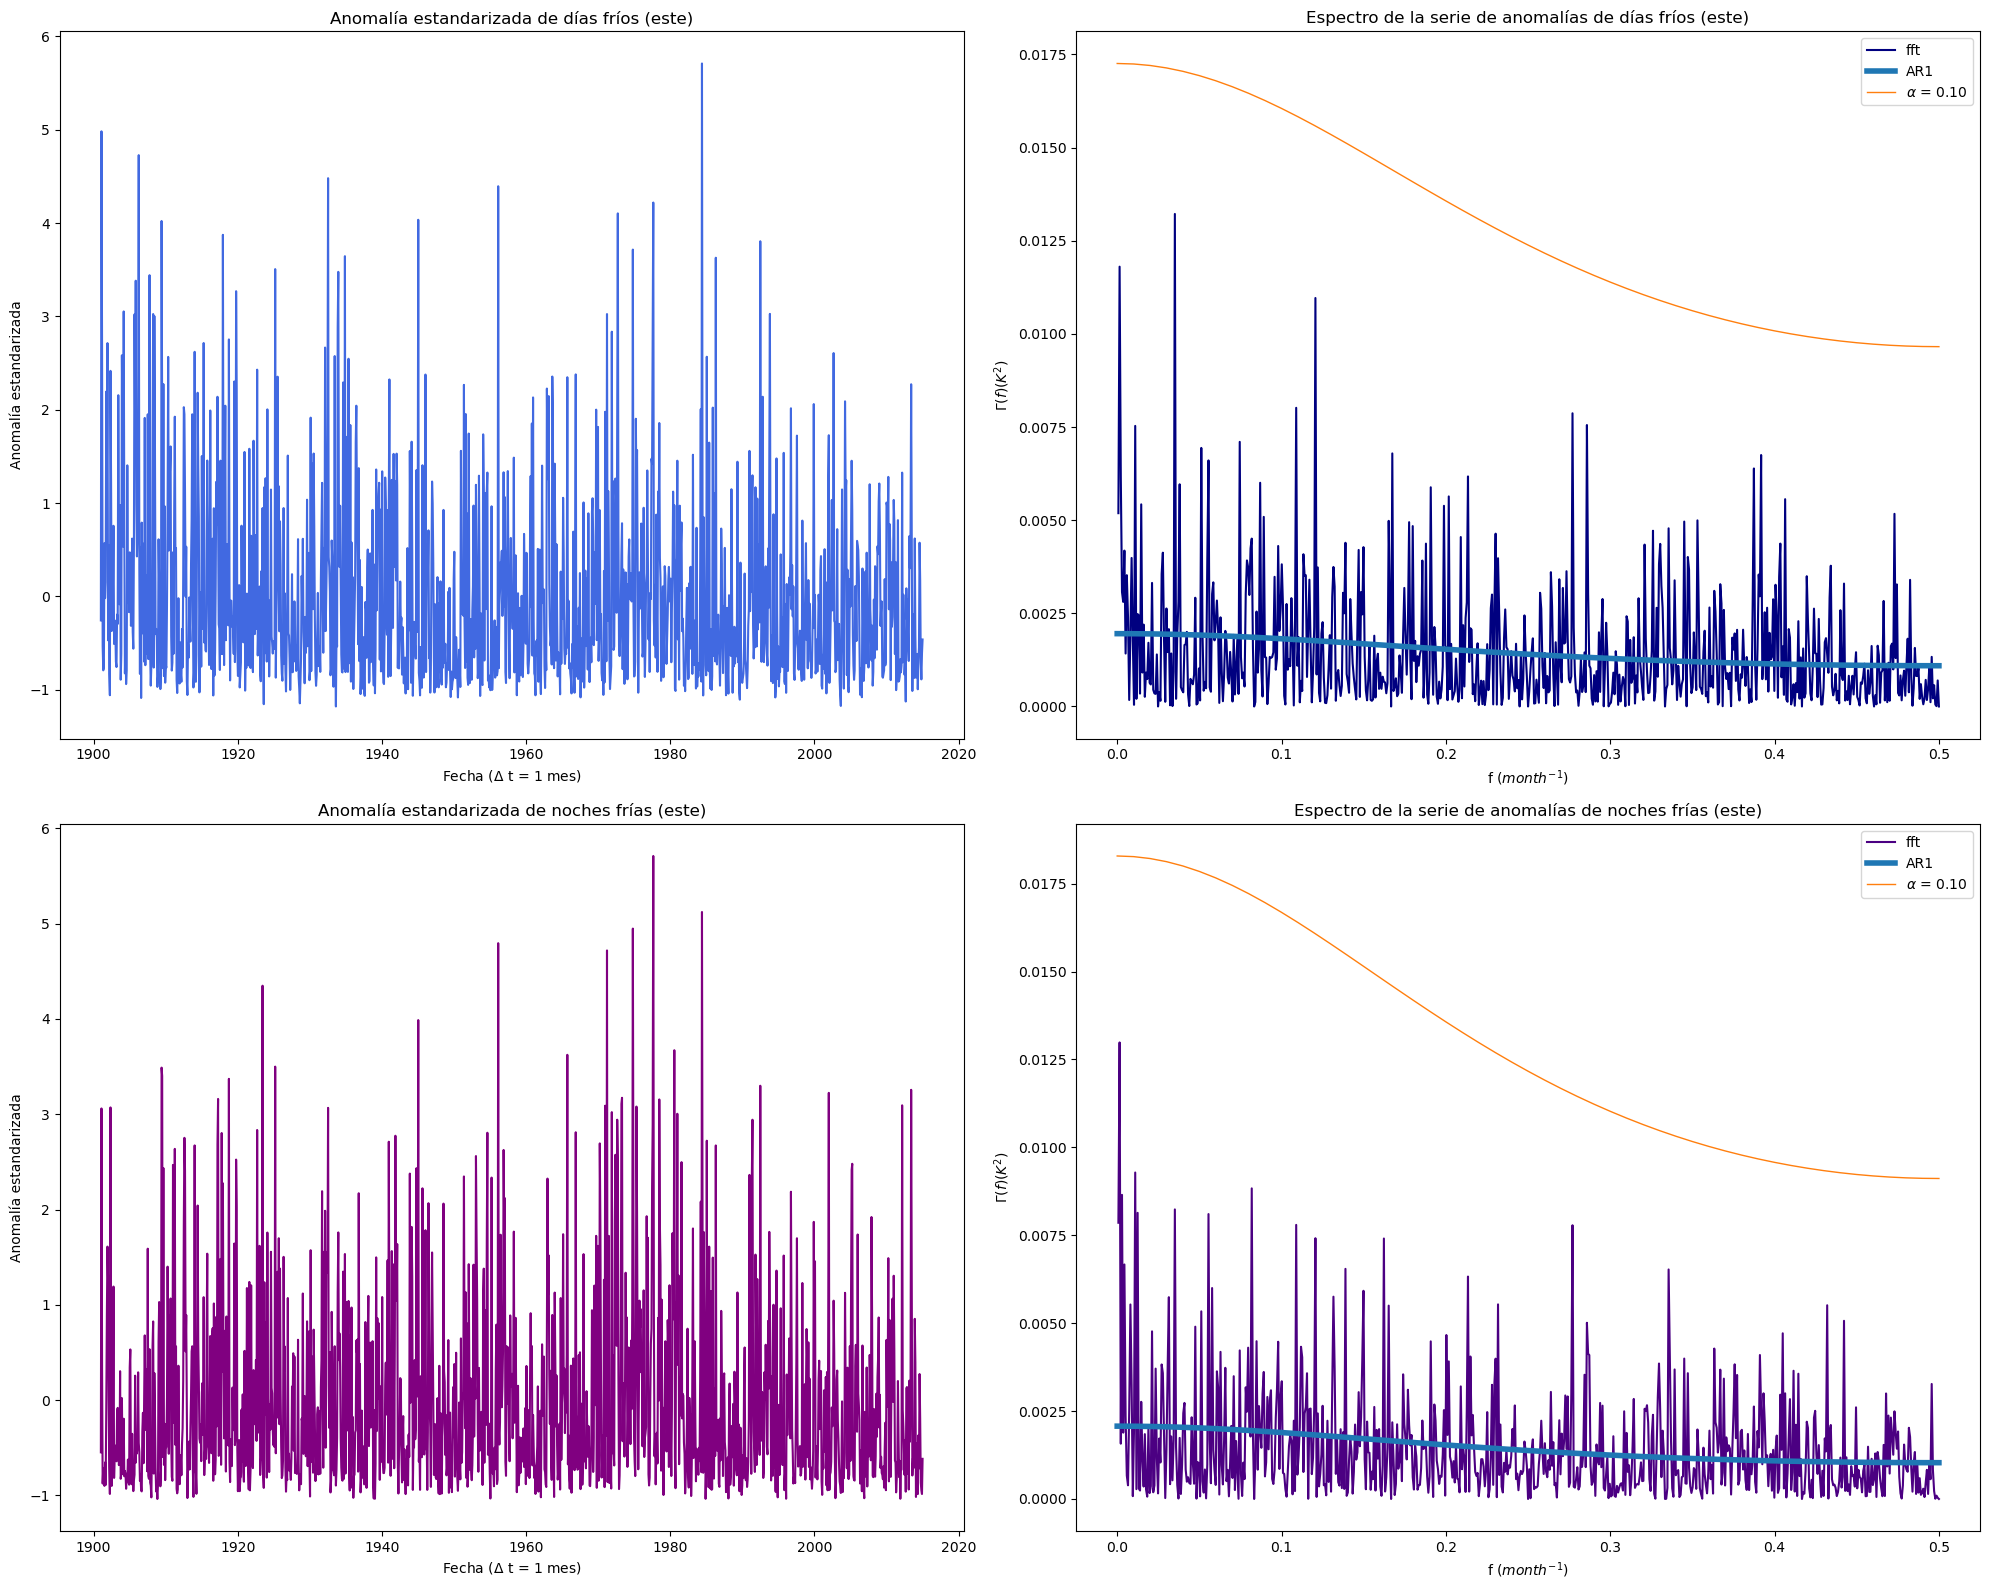

In [42]:
fig,(ax,axd)=plt.subplots(2,2,figsize=(20,16))
años = np.linspace(1901,2015,1368)
x = anom_E_std
ax[0].plot(años,x,color='royalblue')
ax[0].set_ylabel(u'Anomalía estandarizada')
ax[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax[0].set_title(u'Anomalía estandarizada de días fríos (este)')


#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
ax[1].plot(ff,Gf,label='fft',color='navy')
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro de la serie de anomalías de días fríos (este)')

print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax[1].legend()


x = anom_nights_E_std
axd[0].plot(años,x,color='purple')
axd[0].set_ylabel(u'Anomalía estandarizada')
axd[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
axd[0].set_title(u'Anomalía estandarizada de noches frías (este)')


#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
axd[1].plot(ff,Gf,label='fft',color='indigo')
axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
axd[1].set_xlabel(r'f ($month^{-1}$)')
axd[1].set_title('Espectro de la serie de anomalías de noches frías (este)')

print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
axd[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
axd[1].legend()


#ax[1].set_xlim(0,0.02)
#axd[1].set_xlim(0,0.02)



plt.tight_layout()

Trabajando con meses no obtengo picos significativos, hay que probar por estaciones

In [43]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

In [44]:
def resample_month_to_season(ds):
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='standard'),
        coords=[ds.time],name='month_length')

    result = ((ds * month_length/100).resample(time='QS-DEC').sum() / 
            month_length.resample(time='QS-DEC').sum())*100
    return result
corr_days_E_est = resample_month_to_season(corr_days_E_mes)
corr_nights_E_est = resample_month_to_season(corr_nights_E_mes)

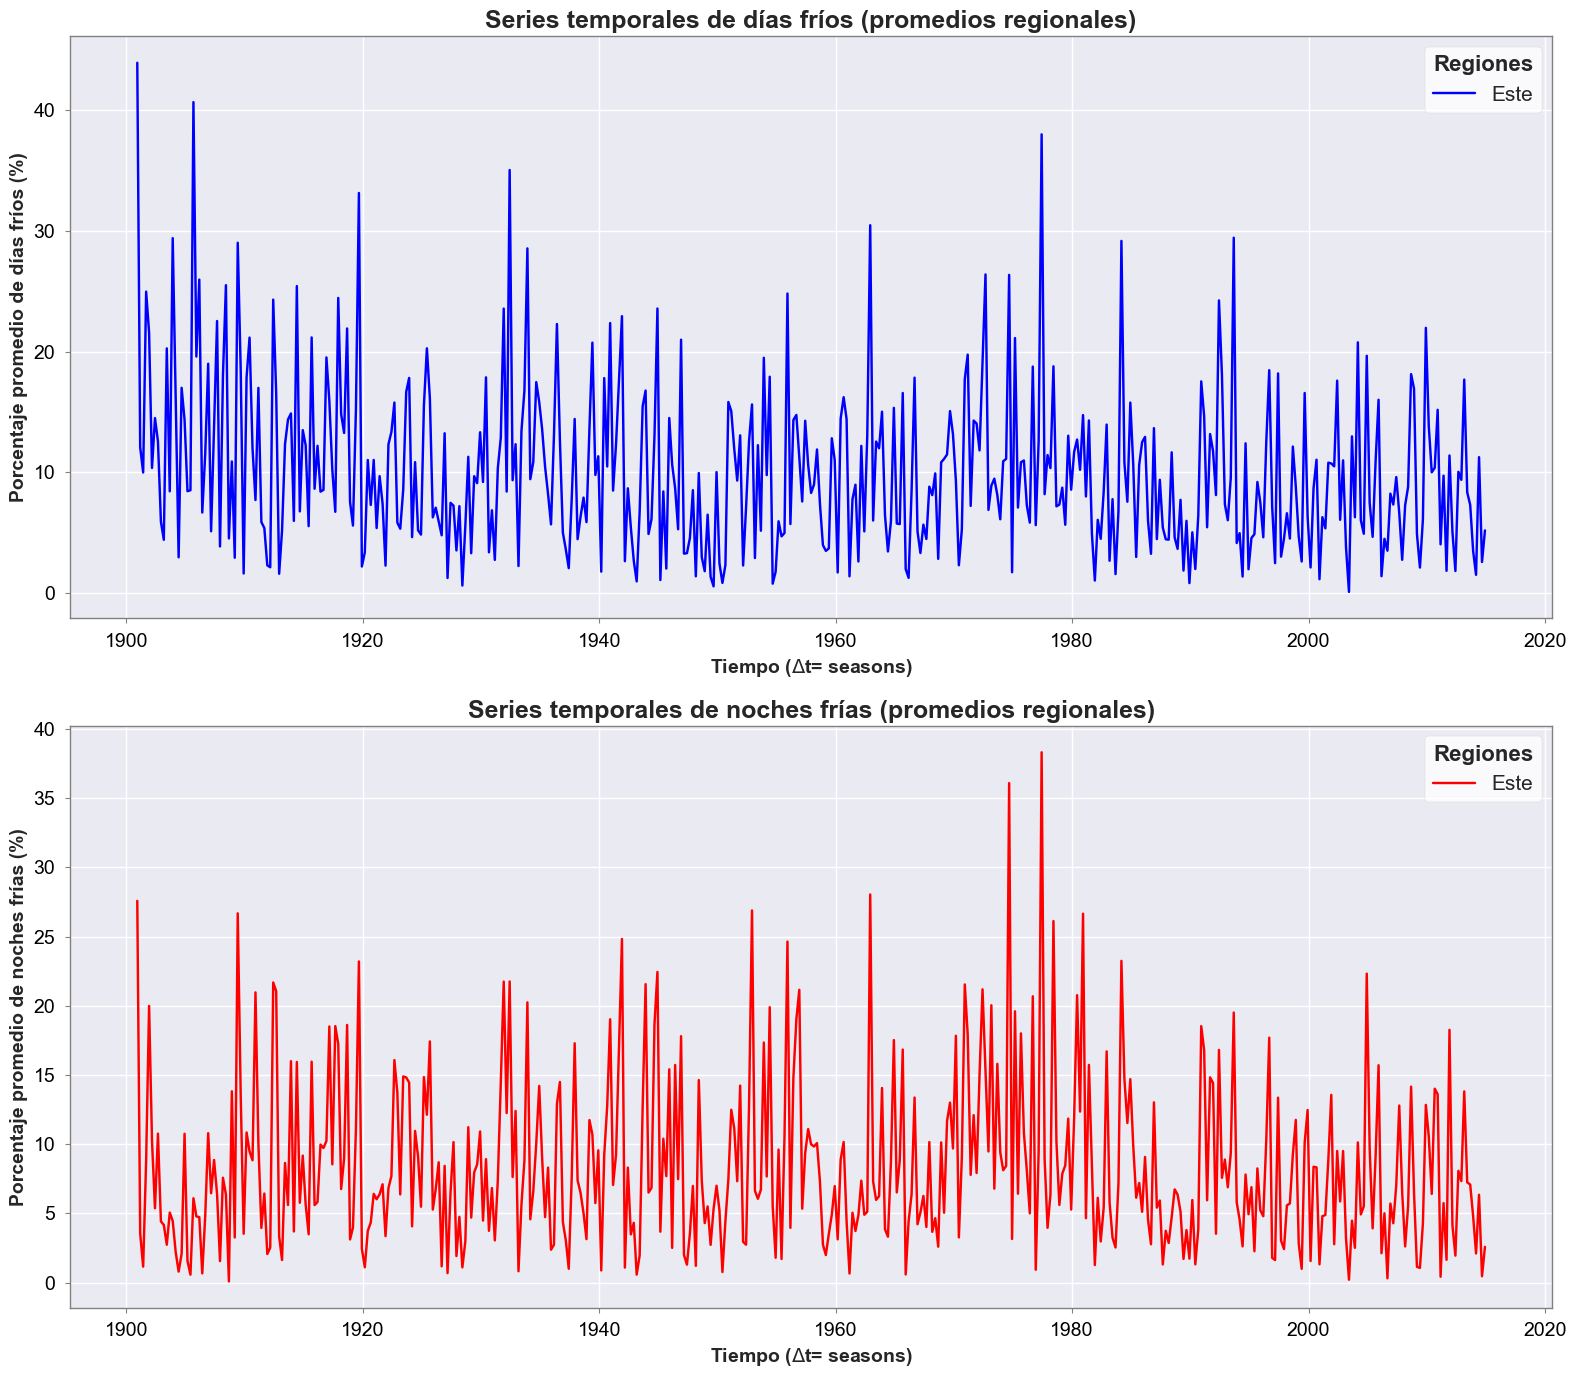

In [45]:
series_style()
fig, (ax,ax2) = plt.subplots(2,1,figsize = (16,14))

var = corr_days_E_est
ax.plot(var.time,var ,color='blue',label='Este')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(r'Tiempo ($\Delta$t= seasons)')
ax.set_ylabel(u'Porcentaje promedio de días fríos (%)')
ax.set_title('Series temporales de días fríos (promedios regionales)')

var = corr_nights_E_est
ax2.plot(var.time,var ,color='red',label='Este')
ax2.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax2.set_xlabel(r'Tiempo ($\Delta$t= seasons)')
ax2.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax2.set_title('Series temporales de noches frías')
plt.tight_layout()

In [46]:

#PRIMAVERA

corr_nights_E_primavera = corr_nights_E_est.sel(time=(corr_nights_E_est.time.dt.month==3))
corr_days_E_primavera = corr_days_E_est.sel(time=(corr_days_E_est.time.dt.month==3))

#VERANO
corr_nights_E_verano = corr_nights_E_est.sel(time=(corr_nights_E_est.time.dt.month==6))
corr_days_E_verano = corr_days_E_est.sel(time=(corr_days_E_est.time.dt.month==6))

#OTOÑO
corr_nights_E_oto = corr_nights_E_est.sel(time=(corr_nights_E_est.time.dt.month==9))
corr_days_E_oto = corr_days_E_est.sel(time=(corr_days_E_est.time.dt.month==9))

#INVIERNO
corr_nights_E_inv = corr_nights_E_est.sel(time=(corr_nights_E_est.time.dt.month==12))
corr_days_E_inv = corr_days_E_est.sel(time=(corr_days_E_est.time.dt.month==12))


In [47]:
def armonics_plot(days,nights,season):

    fig,(ax,axd)=plt.subplots(2,2,figsize=(20,16))


    # Fila de arriba
    var = days
    x = (var-var.mean())/var.std() # Calculo la anomalía
    ax[0].plot(x.time,x,color='royalblue')
    ax[0].set_ylabel(u'Anomalía estandarizada')
    ax[0].set_xlabel(r'%s de cada año'%(season))
    ax[0].set_title(u'Anomalía estandarizada de días fríos (este)')


    #fa,Ga = espectroArmonico(x,1)
    ff,Gf = espectroFFT(x,1)
    #ax[1].plot(fa,Ga,linewidth=1)
    ax[1].plot(ff,Gf,label='fft',color='navy')
    ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
    ax[1].set_xlabel(r'f ($año^{-1}$)')
    ax[1].set_title('Espectro de la serie de anomalías de días fríos (este)')

    print('La varianza de la serie es ',float(np.var(x)))
    print('La integral del espectro es ',sum(Gf))


    #Veamos si los picos sobresalen lo suficiente:
    alpha = 0.1
    alphaS = alpha / Gf.size
    nu = 2
    chi2 = stats.chi2.ppf(1-alphaS,2)
    N = x.size
    s2 = float(np.var(x))
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    #a = 0 #Para ruido blanco
    f,G = redSpectra(a,s2)
    ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
    Gmax = G/x.size/nu*chi2
    ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
    a,s2,chi2
    ax[1].legend()



    # Fila de abajo
    var = nights
    x = (var-var.mean())/var.std() # Calculo la anomalía
    axd[0].plot(x.time,x,color='purple')
    axd[0].set_ylabel(u'Anomalía estandarizada')
    axd[0].set_xlabel(r'%s de cada año'%(season))
    axd[0].set_title(u'Anomalía estandarizada de noches frías (este)')


    #fa,Ga = espectroArmonico(x,1)
    ff,Gf = espectroFFT(x,1)
    #ax[1].plot(fa,Ga,linewidth=1)
    axd[1].plot(ff,Gf,label='fft',color='indigo')
    axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
    axd[1].set_xlabel(r'f ($año^{-1}$)')
    axd[1].set_title('Espectro de la serie de anomalías de noches frías (este)')

    print('La varianza de la serie es ',float(np.var(x)))
    print('La integral del espectro es ',sum(Gf))


    #Veamos si los picos sobresalen lo suficiente:
    alpha = 0.1
    alphaS = alpha / Gf.size
    nu = 2
    chi2 = stats.chi2.ppf(1-alphaS,2)
    N = x.size
    s2 = float(np.var(x))
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    # a = 0 #Para ruido blanco
    f,G = redSpectra(a,s2)
    axd[1].plot(f,G/x.size,linewidth=4,label='AR1')
    Gmax = G/x.size/nu*chi2
    axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
    a,s2,chi2
    axd[1].legend()

    fig.suptitle(r'%s'%(season),size=26,weight='bold')

    #ax[1].set_xlim(0,0.02)
    #axd[1].set_xlim(0,0.02)



    plt.tight_layout()
    return fig, (ax,axd)

La varianza de la serie es  0.9999999999999999
La integral del espectro es  1.0098242852218828
La varianza de la serie es  1.0000000000000004
La integral del espectro es  1.0041864915472167
La varianza de la serie es  1.0000000000000007
La integral del espectro es  1.0119947456606273
La varianza de la serie es  1.0
La integral del espectro es  1.0146719334800183
La varianza de la serie es  1.0000000000000007
La integral del espectro es  1.0091362619640905
La varianza de la serie es  1.0
La integral del espectro es  1.0001934824480307
La varianza de la serie es  0.9999999999999997
La integral del espectro es  0.9999999999999997
La varianza de la serie es  1.0000000000000002
La integral del espectro es  0.9999999999999997


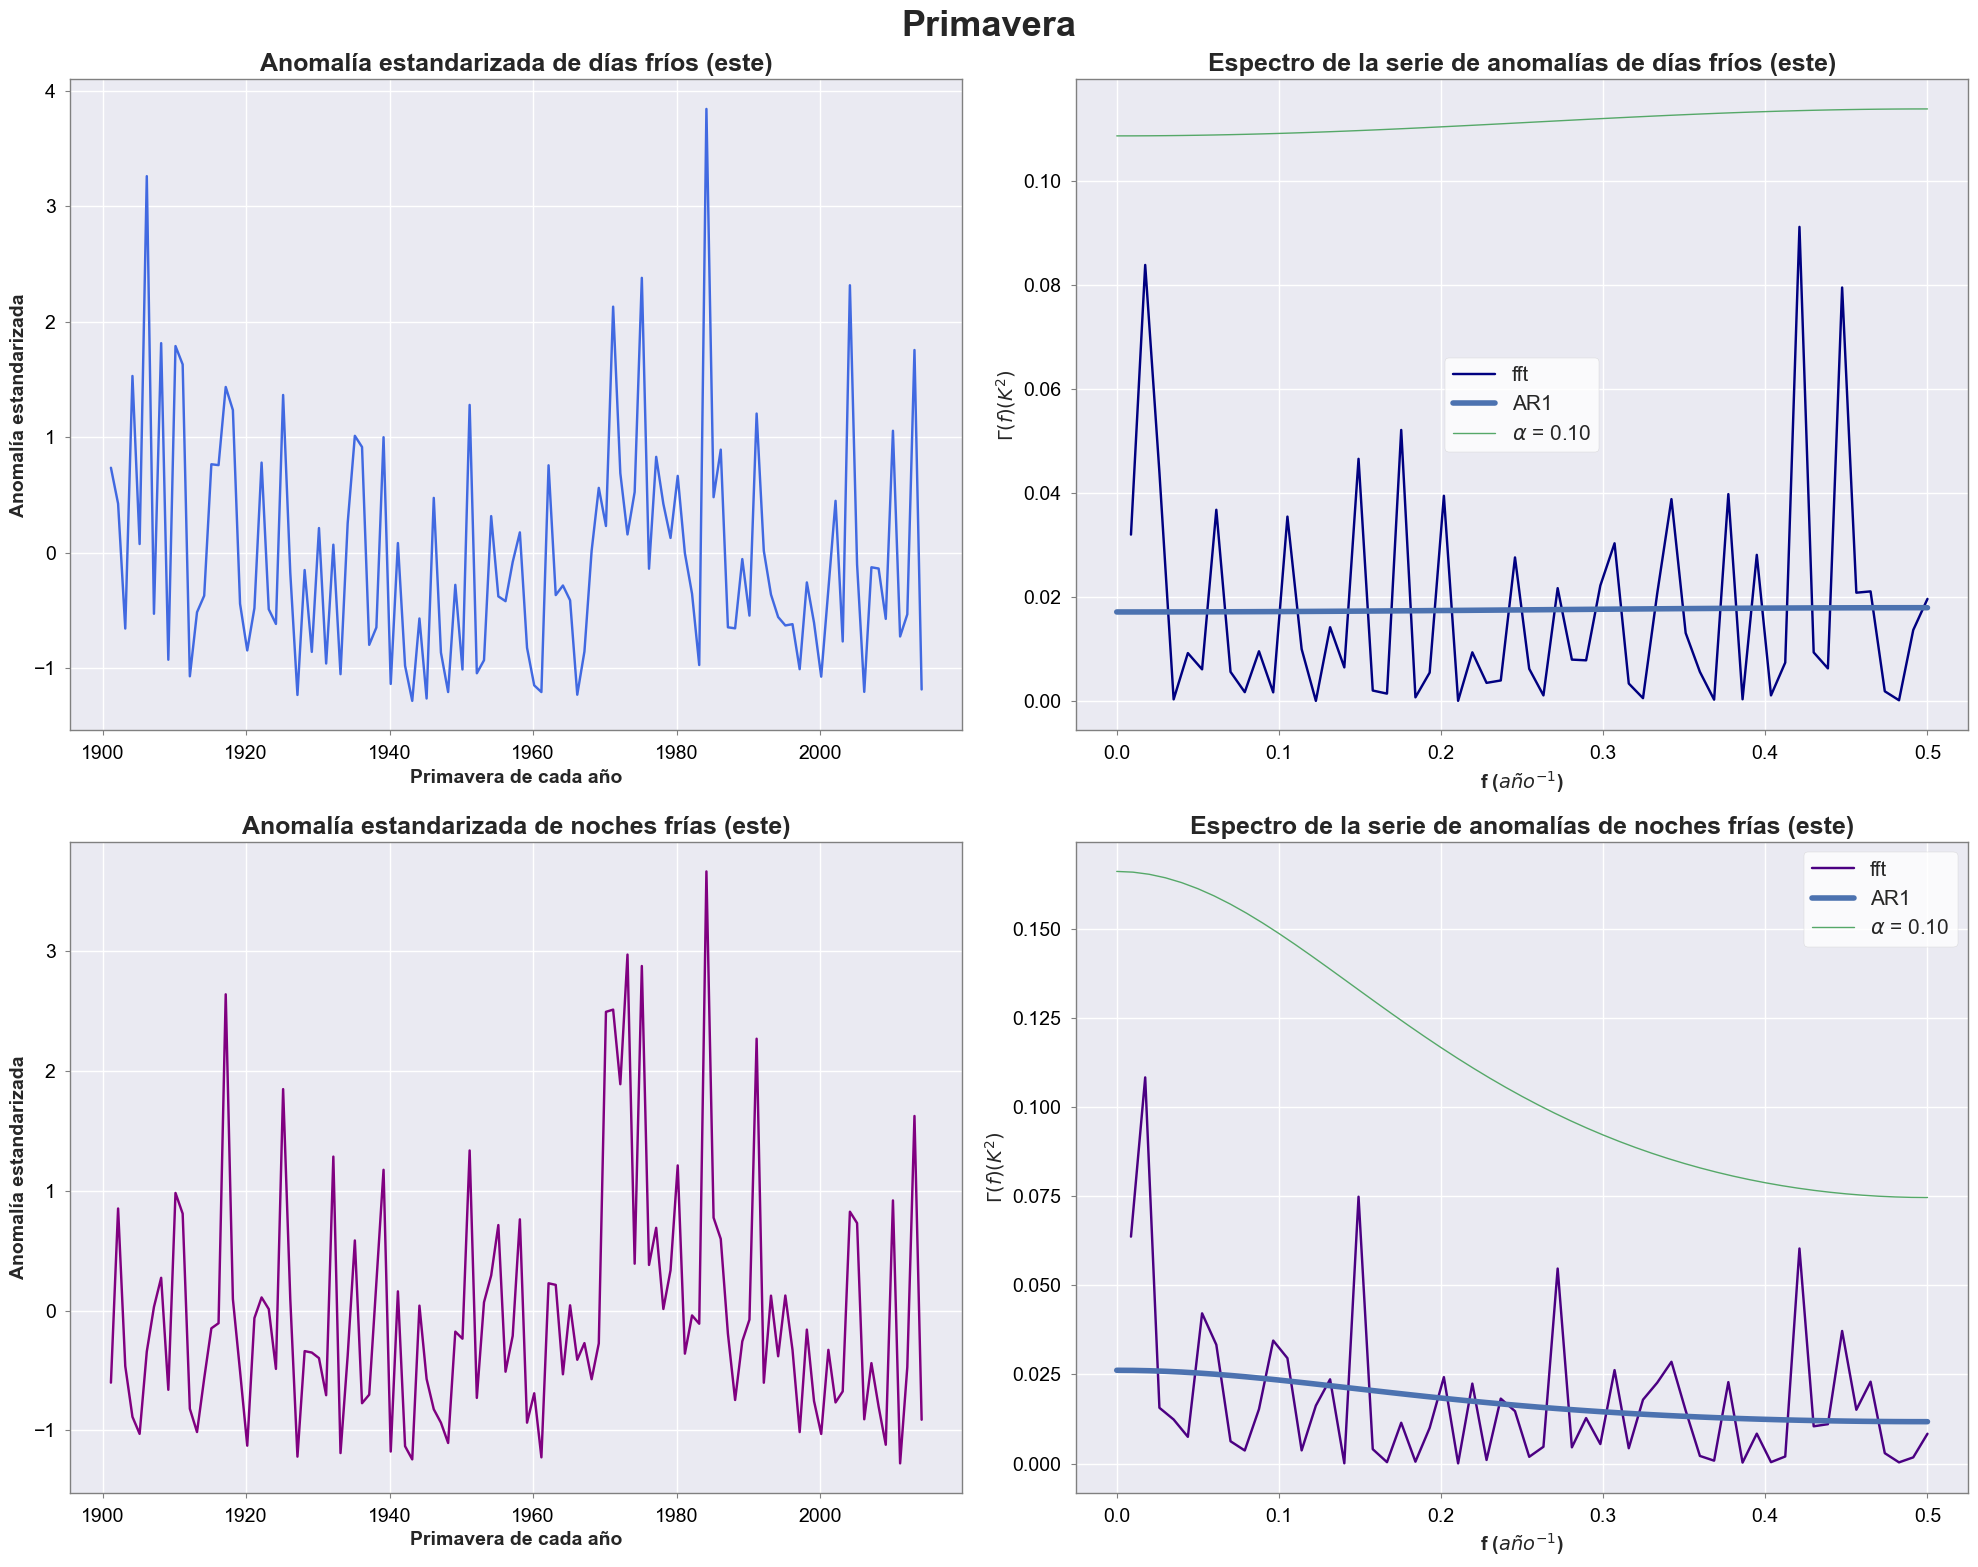

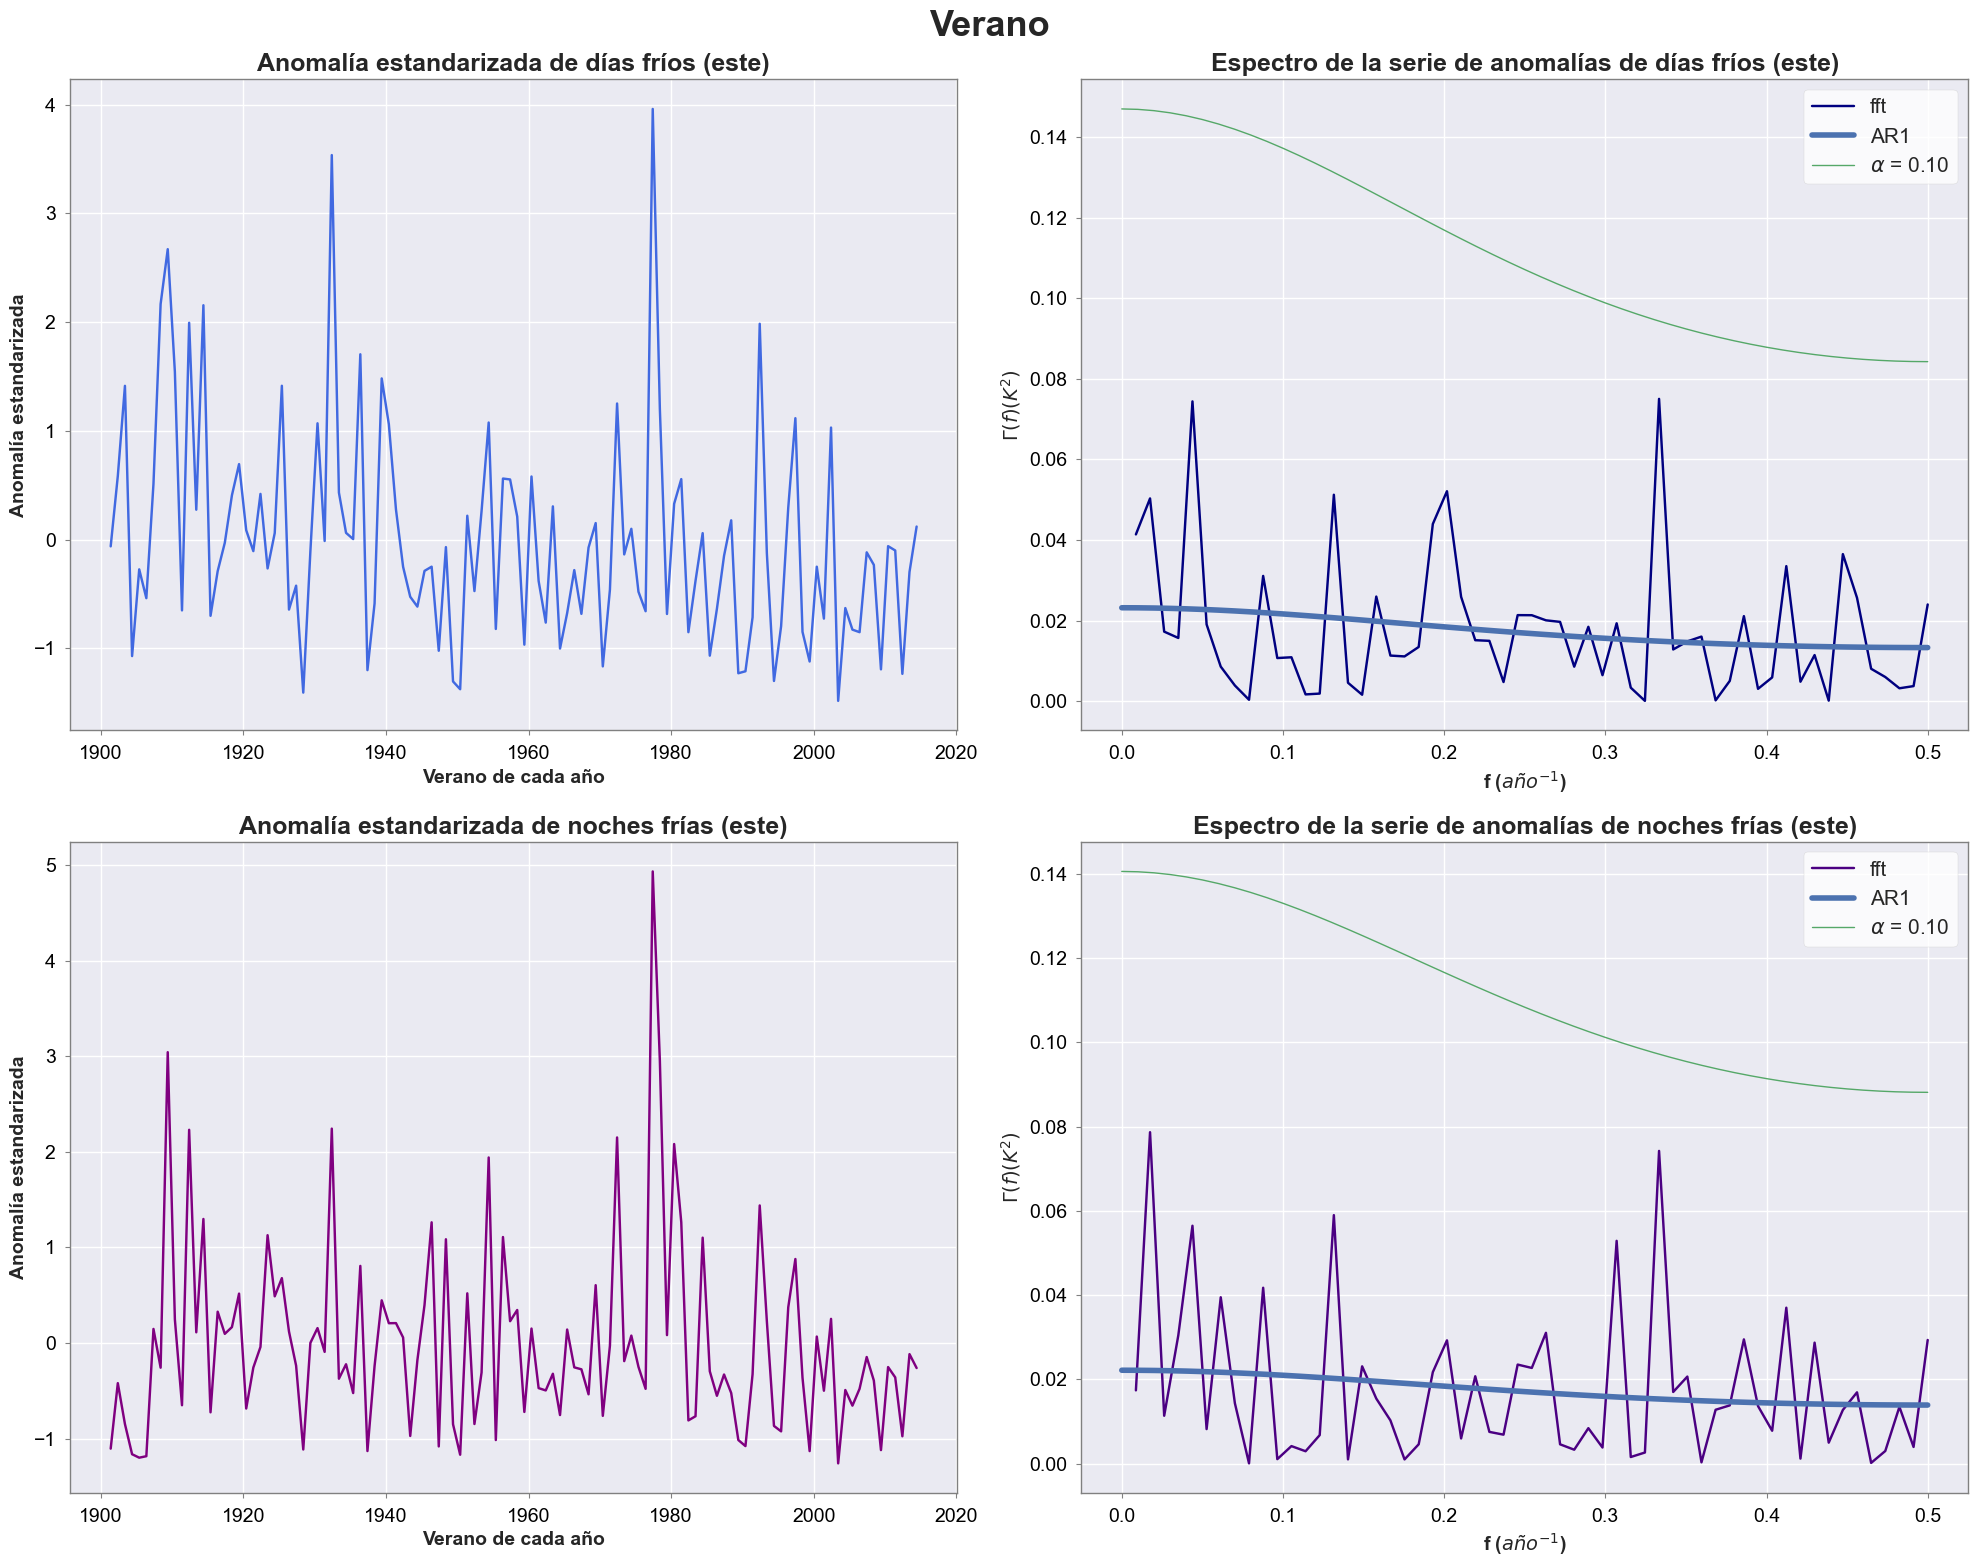

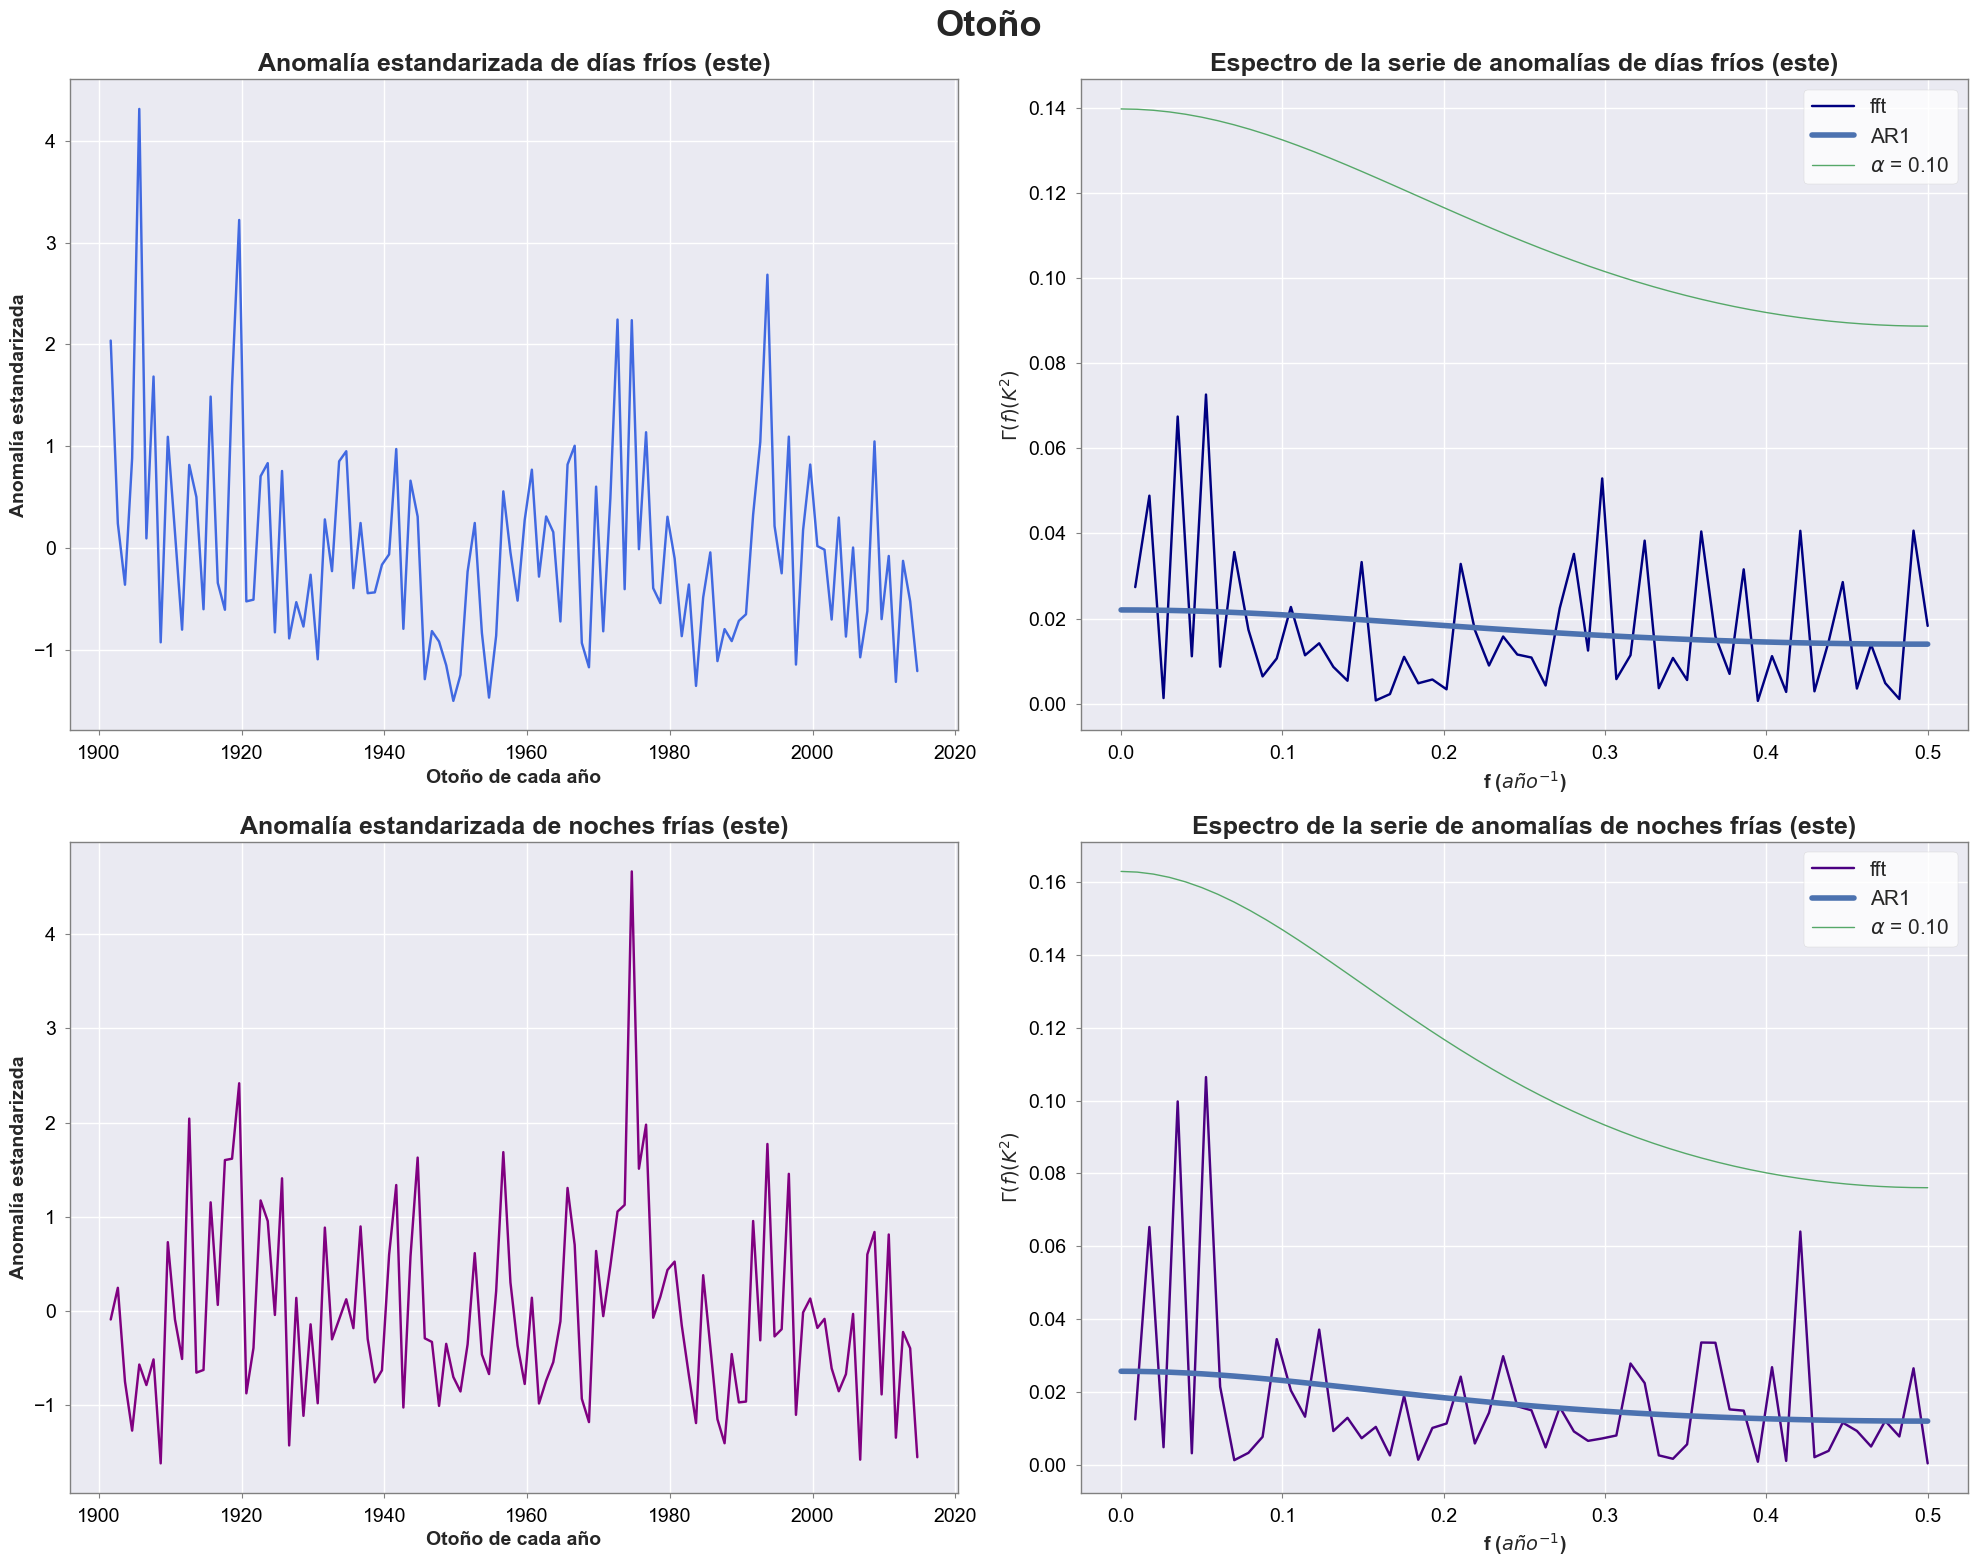

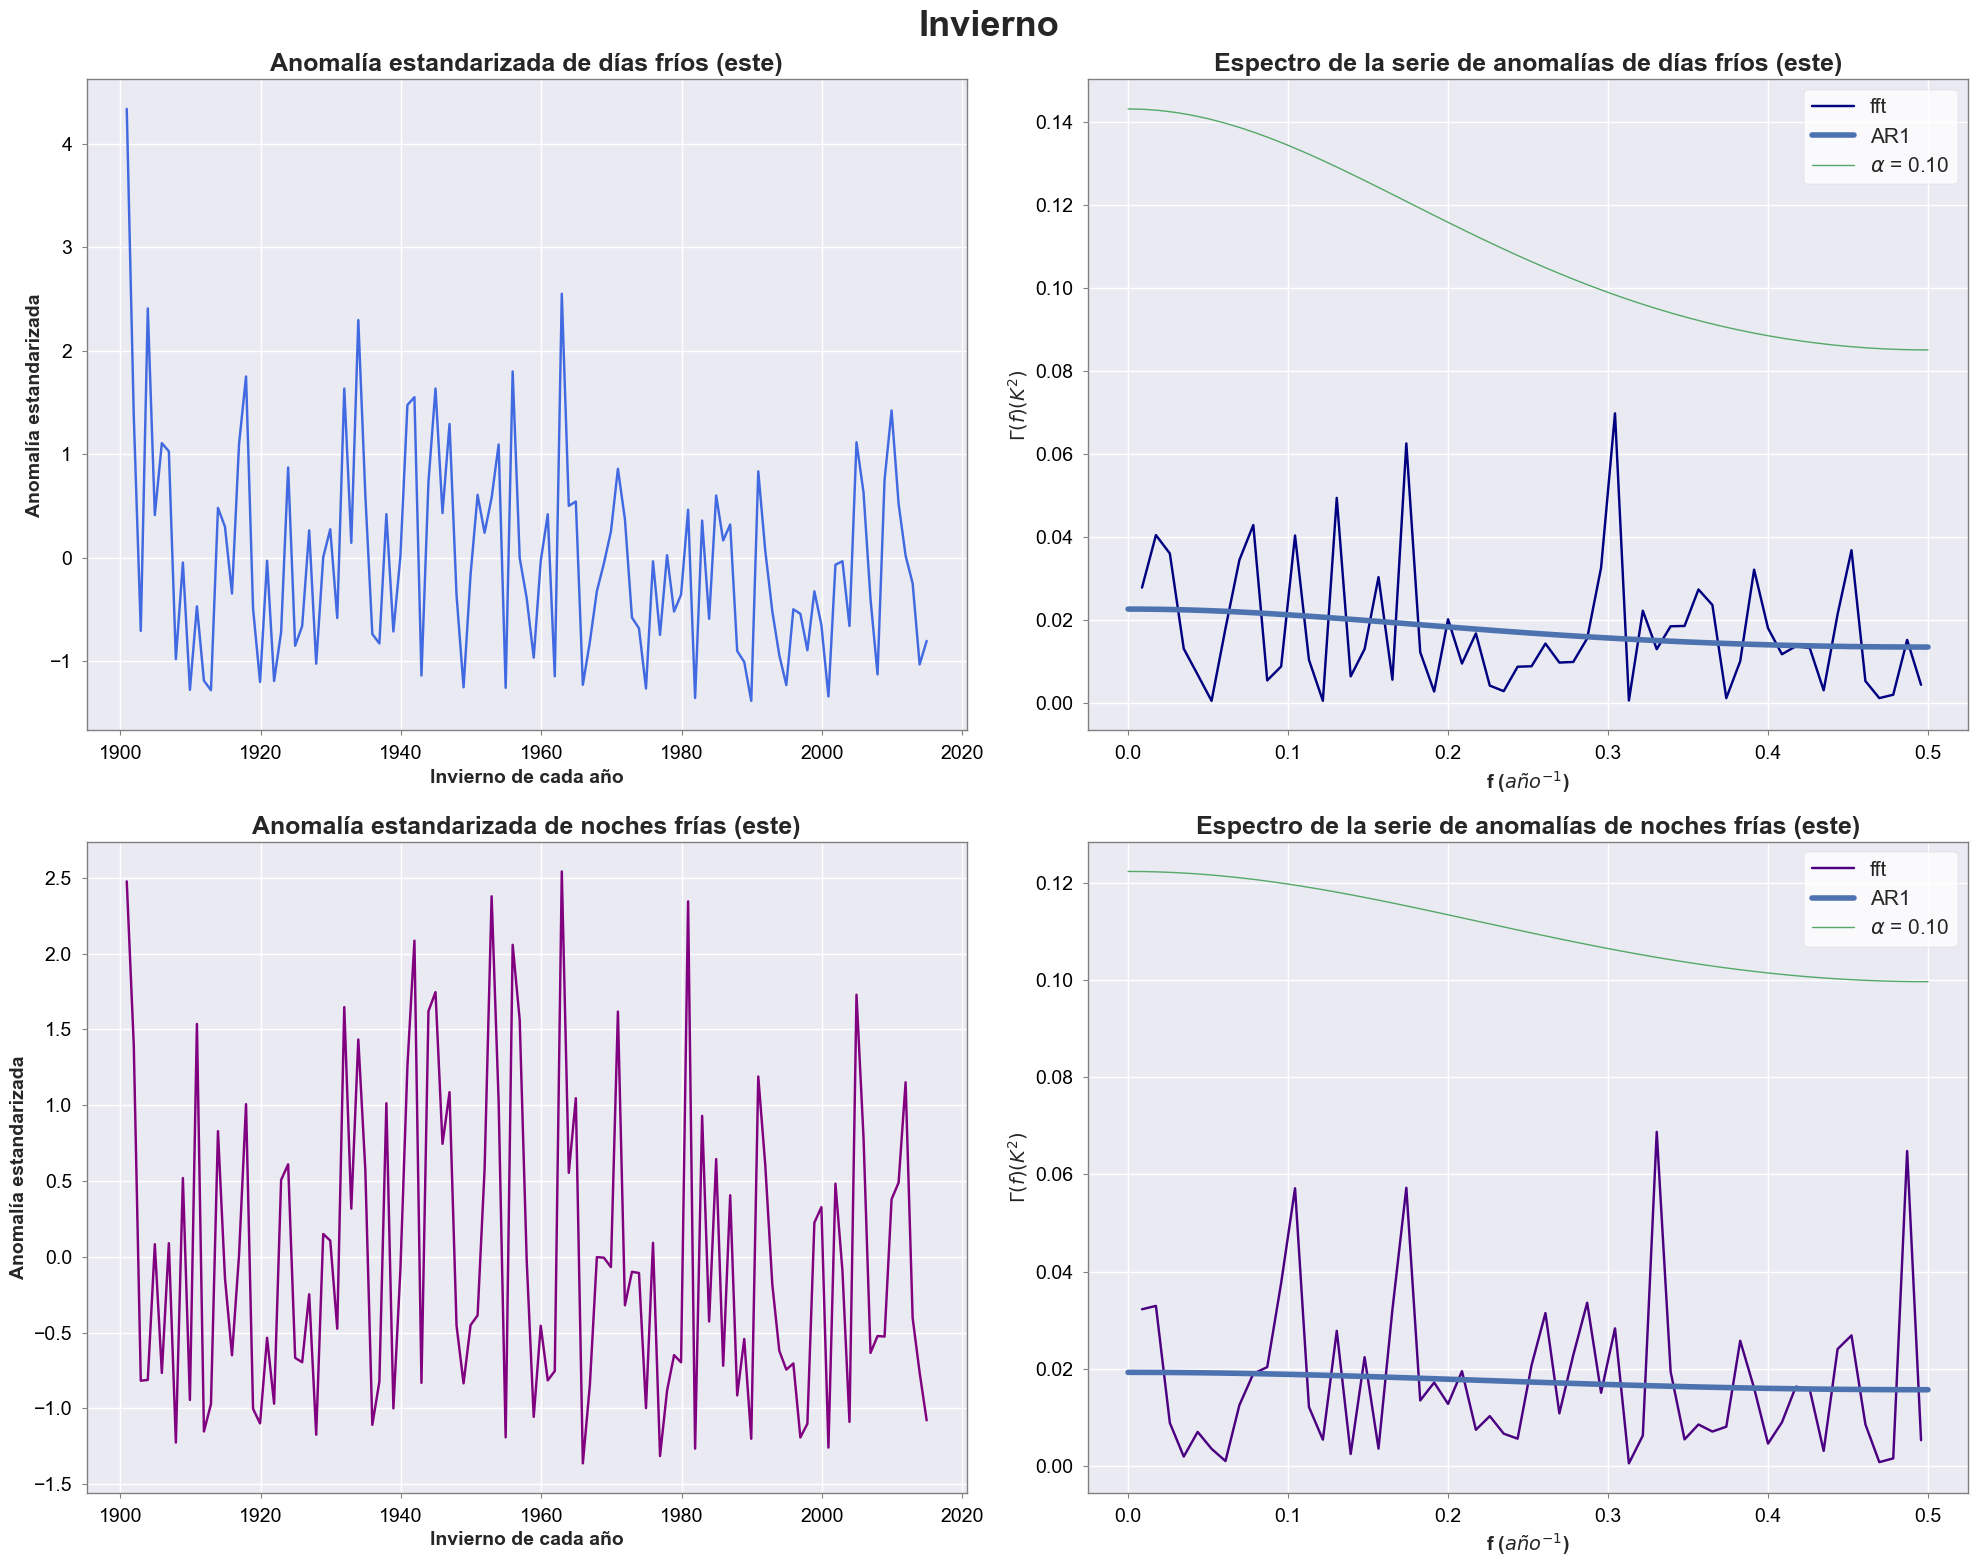

In [48]:
fig, (ax,axd) = armonics_plot(corr_days_E_primavera,corr_nights_E_primavera,'Primavera')

fig, (ax,axd) = armonics_plot(corr_days_E_verano,corr_nights_E_verano,'Verano')

fig, (ax,axd) = armonics_plot(corr_days_E_oto,corr_nights_E_oto,'Otoño')

fig, (ax,axd) = armonics_plot(corr_days_E_inv,corr_nights_E_inv,'Invierno')

In [49]:
def espect_comp(prim,ver,oto,inv):
    fig,(ax,axd)=plt.subplots(2,2,figsize=(20,16))


    # Fila de arriba
    var1 = prim
    x1 = (var1-var1.mean())/var1.std() # Calculo la anomalía
    ff,Gf = espectroFFT(x1,1)
    ax[0].plot(ff,Gf,label='fft',color='navy')
    ax[0].set_ylabel(r'$\Gamma(f) (K^2)$')
    ax[0].set_xlabel(r'f ($año^{-1}$)')
    ax[0].set_title('Espectro de la serie de anomalías de días fríos (este)')


    var2 = ver
    x2 = (var2-var2.mean())/var2.std() # Calculo la anomalía
    ff,Gf = espectroFFT(x2,1)
    ax[1].plot(ff,Gf,label='fft',color='navy')
    ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
    ax[1].set_xlabel(r'f ($año^{-1}$)')
    ax[1].set_title('Espectro de la serie de anomalías de días fríos (este)')

    # print('La varianza de la serie es ',float(np.var(x)))
    # print('La integral del espectro es ',sum(Gf))

    
    #Veamos si los picos sobresalen lo suficiente:
    alpha = 0.1
    alphaS = alpha / Gf.size
    nu = 2
    chi2 = stats.chi2.ppf(1-alphaS,2)
    N = x1.size
    s2 = float(np.var(x1))
    cor = stattools.acf(x1, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    #a = 0 #Para ruido blanco
    f,G = redSpectra(a,s2)
    ax[0].plot(f,G/x1.size,linewidth=4,label='AR1')
    Gmax = G/x1.size/nu*chi2
    ax[0].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
    a,s2,chi2
    ax[0].legend()

    ax[1].plot(f,G/x2.size,linewidth=4,label='AR1')
    Gmax = G/x2.size/nu*chi2
    ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
    a,s2,chi2
    ax[1].legend()



    # Fila de abajo
    var3 = oto
    x = (var3-var3.mean())/var3.std() # Calculo la anomalía
    ff,Gf = espectroFFT(x,1)
    #ax[1].plot(fa,Ga,linewidth=1)
    axd[0].plot(ff,Gf,label='fft',color='indigo')
    axd[0].set_ylabel(r'$\Gamma(f) (K^2)$')
    axd[0].set_xlabel(r'f ($año^{-1}$)')
    axd[0].set_title('Espectro de la serie de anomalías de noches frías (oto)')

    var4= inv
    x3 = (var4-var4.mean())/var4.std() # Calculo la anomalía
    #fa,Ga = espectroArmonico(x,1)
    ff,Gf = espectroFFT(x3,1)
    #ax[1].plot(fa,Ga,linewidth=1)
    axd[1].plot(ff,Gf,label='fft',color='indigo')
    axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
    axd[1].set_xlabel(r'f ($año^{-1}$)')
    axd[1].set_title('Espectro de la serie de anomalías de noches frías (este)')

    # print('La varianza de la serie es ',float(np.var(x)))
    # print('La integral del espectro es ',sum(Gf))


    #Veamos si los picos sobresalen lo suficiente:
    alpha = 0.1
    alphaS = alpha / Gf.size
    nu = 2
    chi2 = stats.chi2.ppf(1-alphaS,2)
    N = x.size
    s2 = float(np.var(x))
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    # a = 0 #Para ruido blanco
    f,G = redSpectra(a,s2)
    axd[1].plot(f,G/x.size,linewidth=4,label='AR1')
    Gmax = G/x.size/nu*chi2
    axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
    a,s2,chi2
    axd[1].legend()


    #ax[1].set_xlim(0,0.02)
    #axd[1].set_xlim(0,0.02)



    plt.tight_layout()
    return fig, (ax,axd)

In [50]:
# fig, (ax,axd) = espect_comp(corr_days_E_primavera,corr_days_E_verano,corr_days_E_oto,corr_days_E_inv)

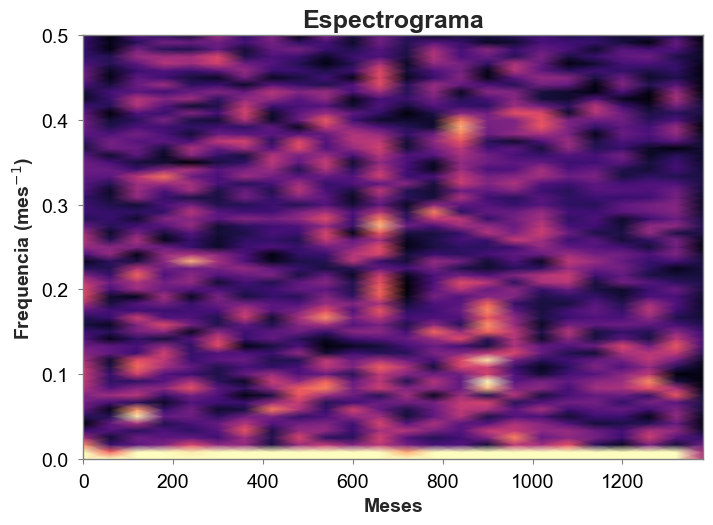

In [51]:
# Lo hago a partir del ejemplo de scipy
x= corr_nights_E_mes
f, t, Zxx = signal.stft(x, 1, nperseg=10*12)
Zabs = np.abs(Zxx)
plt.pcolormesh(t, f, Zabs, vmin=0, vmax=Zabs.max()/4,cmap='magma', shading='gouraud')
plt.title('Espectrograma')
plt.ylabel(r'Frequencia (mes$^{-1}$)')
plt.xlabel('Meses')
plt.show()